In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

import pandas as pd
import numpy as np
import html
import matplotlib.pyplot as plt


In [3]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2655800/
# https://lena-voita.github.io/nlp_course/language_modeling.html
# https://en.wikipedia.org/wiki/Perplexity
# https://github.com/singnet/language-learning/issues/255
# https://medium.com/mlearning-ai/word-embeddings-wordpiece-and-language-agnostic-bert-labse-98c7626878c7


In [4]:
feeds_df = pd.read_csv('data/media/crypto_twitter_reddit_20220313.tsv',sep ='\t')
print(len(feeds_df))


161823


In [5]:
feeds_df

,Unnamed: 0,time,type,link,permalink,text
0,0,2021-05-04 11:13:44+00:00,twitter,https://twitter.com/ethhub_io,https://twitter.com/ethhub_io/status/138953872...,RT @sassal0x: The last week in Ethereum: -@Me...
1,1,2021-05-04 18:45:38+00:00,twitter,https://twitter.com/ethhub_io,https://twitter.com/ethhub_io/status/138965245...,RT @econoar: EthHub Weekly #164 -ETH hits $35...
2,2,2021-05-07 23:34:45+00:00,reddit,https://www.reddit.com/r/ethereum/,/r/ethereum/comments/n71ai7/eth_20_and_what_wi...,"Eth 2.0 and ""what will happen to your ETH"" Can..."
3,3,2021-05-11 06:43:32+00:00,twitter,https://twitter.com/ethhub_io,https://twitter.com/ethhub_io/status/139200744...,RT @sassal0x: The last week in Ethereum: -@va...
4,4,2021-05-12 16:11:03+00:00,twitter,https://twitter.com/ethereumJoseph,https://twitter.com/ethereumJoseph/status/1392...,"Layer 2 technology is helping scale #Ethereum,..."
...,...,...,...,...,...,...
161818,161818,2022-03-12 23:00:01+00:00,twitter,https://twitter.com/WeekInEthNews,https://twitter.com/WeekInEthNews/status/15027...,@StarbloomVent @evan_van_ness @showkarma_xyz h...
161819,161819,2022-03-12 23:00:36+00:00,twitter,https://twitter.com/Cointelegraph,https://twitter.com/Cointelegraph/status/15027...,Power to the people. Despite 15% of BItcoin ...
161820,161820,2022-03-12 23:06:05+00:00,twitter,https://twitter.com/tanzeel_akhtar,https://twitter.com/Tanzeel_Akhtar/status/1502...,@zackvoell @fintechfrank @RampCapitalLLC 1 4 D...
161821,161821,2022-03-12 23:20:44+00:00,twitter,https://twitter.com/NeerajKA,https://twitter.com/NeerajKA/status/1502786702...,"@MrHodl throw in a beef braise. or in a stock,..."


In [6]:
def unescape_text(text):
    text = html.unescape(text) # &amp;#x200B; => &#x200B;
    text = html.unescape(text) # &amp;#x200B; =>  
    return text

def preprocess_text(text):
    text = html.unescape(text) # &amp;#x200B; => &#x200B;
    text = html.unescape(text) # &amp;#x200B; =>  
    return text.lower()

def count(dic,arg,cnt=1):
    if arg in dic:
        dic[arg] = dic[arg] + cnt
    else:
        dic[arg] = cnt

def grams_init(max_n):  
    return [{} for n in range(max_n)]

def grams_count(counter,chars,n):
    freqs = counter[n-1]
    #print(chars,n)
    for i in range(len(chars) - (n-1)):
        gram = None
        for j in range(n):
            gram = chars[i+j] if gram is None else gram + chars[i+j]
            #print(i,j,gram)
        count(freqs,gram)

def text_grams_count(counter,text,max_n):
    chars = list(text)
    for n in range(max_n):
        grams_count(counter,chars,n+1)

def merge_two_dicts(x, y):
    """Given two dictionaries, merge them into a new dict as a shallow copy."""
    z = x.copy()
    z.update(y)
    return z


In [7]:
max_n = 6 # https://www.sciencedirect.com/science/article/abs/pii/0378375886901692

counter = grams_init(max_n)
#grams_count(counter,list("abc"),2)
text_grams_count(counter,"abcde",max_n)
text_grams_count(counter,"abcfg",max_n)
counter

[{'a': 2, 'b': 2, 'c': 2, 'd': 1, 'e': 1, 'f': 1, 'g': 1},
 {'ab': 2, 'bc': 2, 'cd': 1, 'de': 1, 'cf': 1, 'fg': 1},
 {'abc': 2, 'bcd': 1, 'cde': 1, 'bcf': 1, 'cfg': 1},
 {'abcd': 1, 'bcde': 1, 'abcf': 1, 'bcfg': 1},
 {'abcde': 1, 'abcfg': 1},
 {}]

In [40]:
max_n = 12 # https://www.sciencedirect.com/science/article/abs/pii/0378375886901692

counters1 = grams_init(max_n)

for text in feeds_df['text']:
    text = preprocess_text(text)
    text_grams_count(counters1,text,max_n)

dfs = []
for i in range(len(counters1)):
    counter = counters1[i]
    df = pd.DataFrame([(gram, counter[gram]) for gram in counter],columns=['gram','freq'])
    df['log'] = np.log10(df['freq'])
    df.sort_values('freq',ascending=False,inplace=True)
    df.title = str(i)
    dfs.append(df)

/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128071 (\N{WHITE DOWN POINTING BACKHAND INDEX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarni

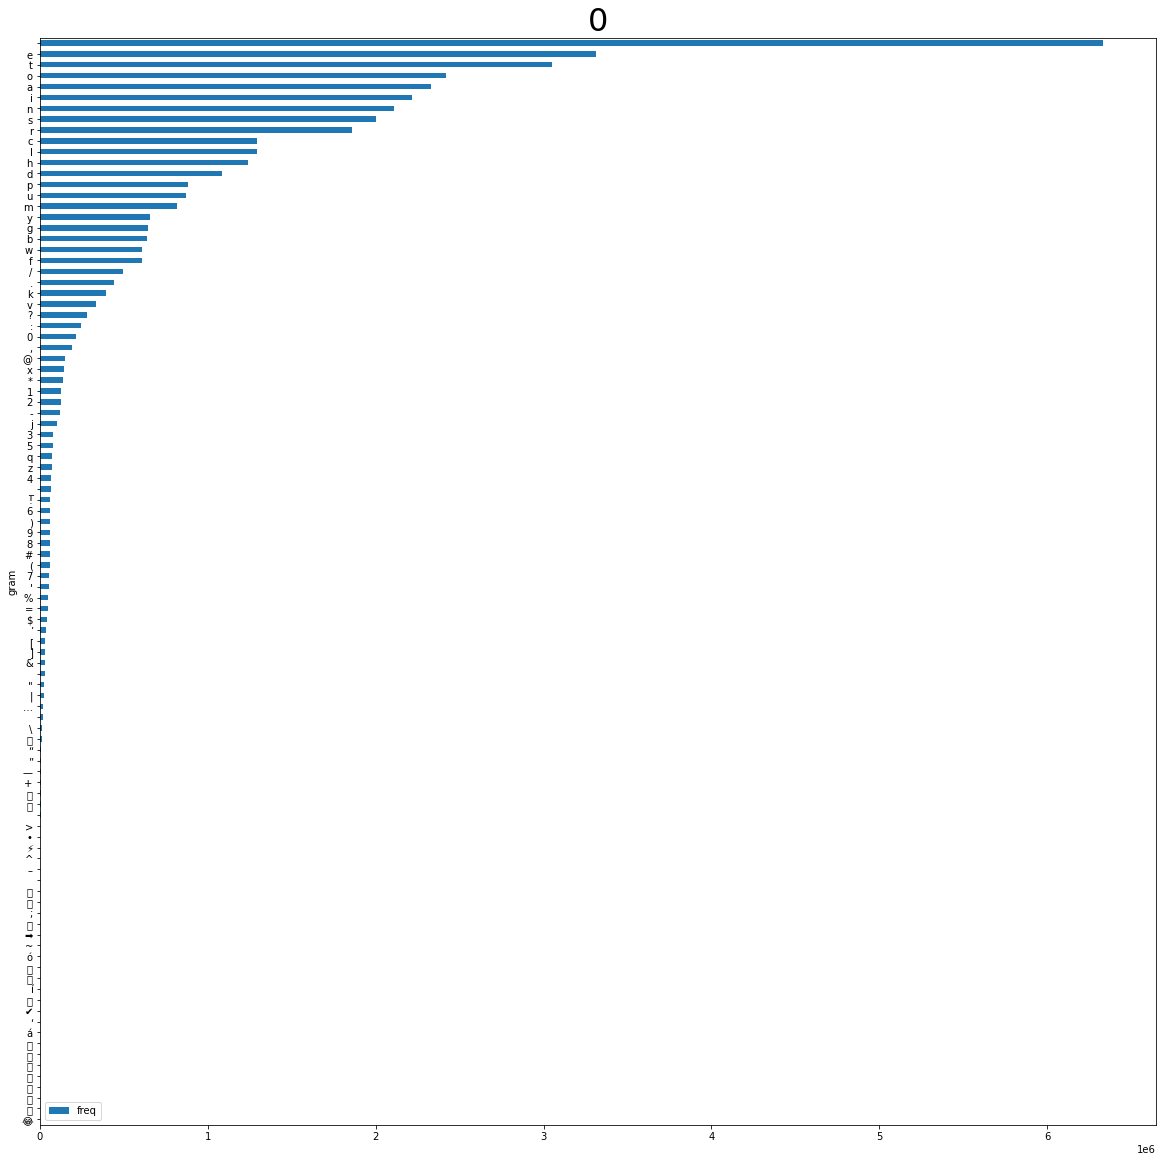

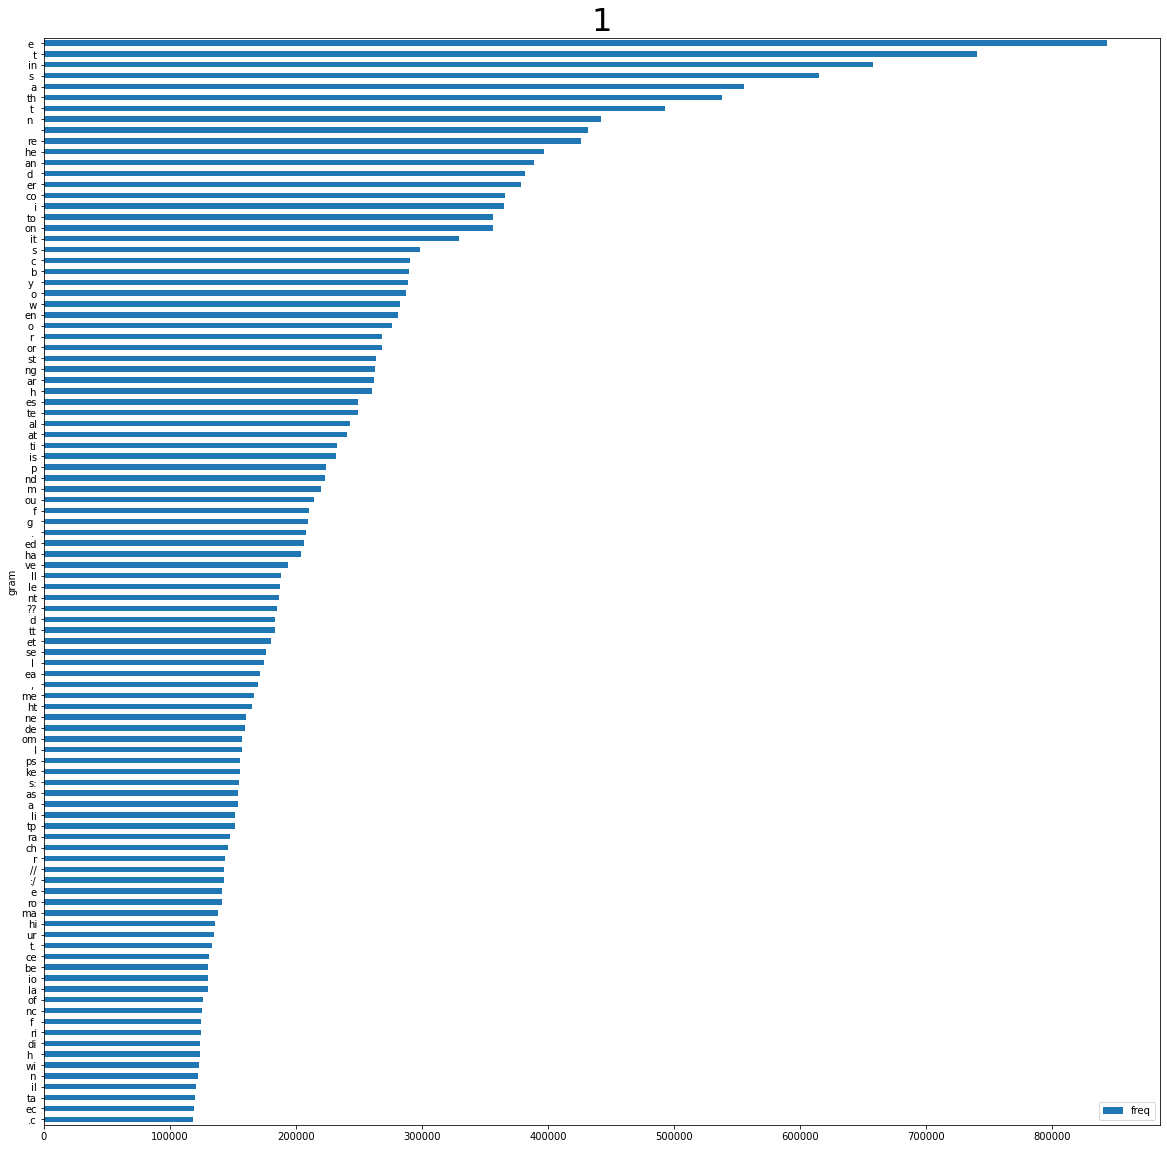

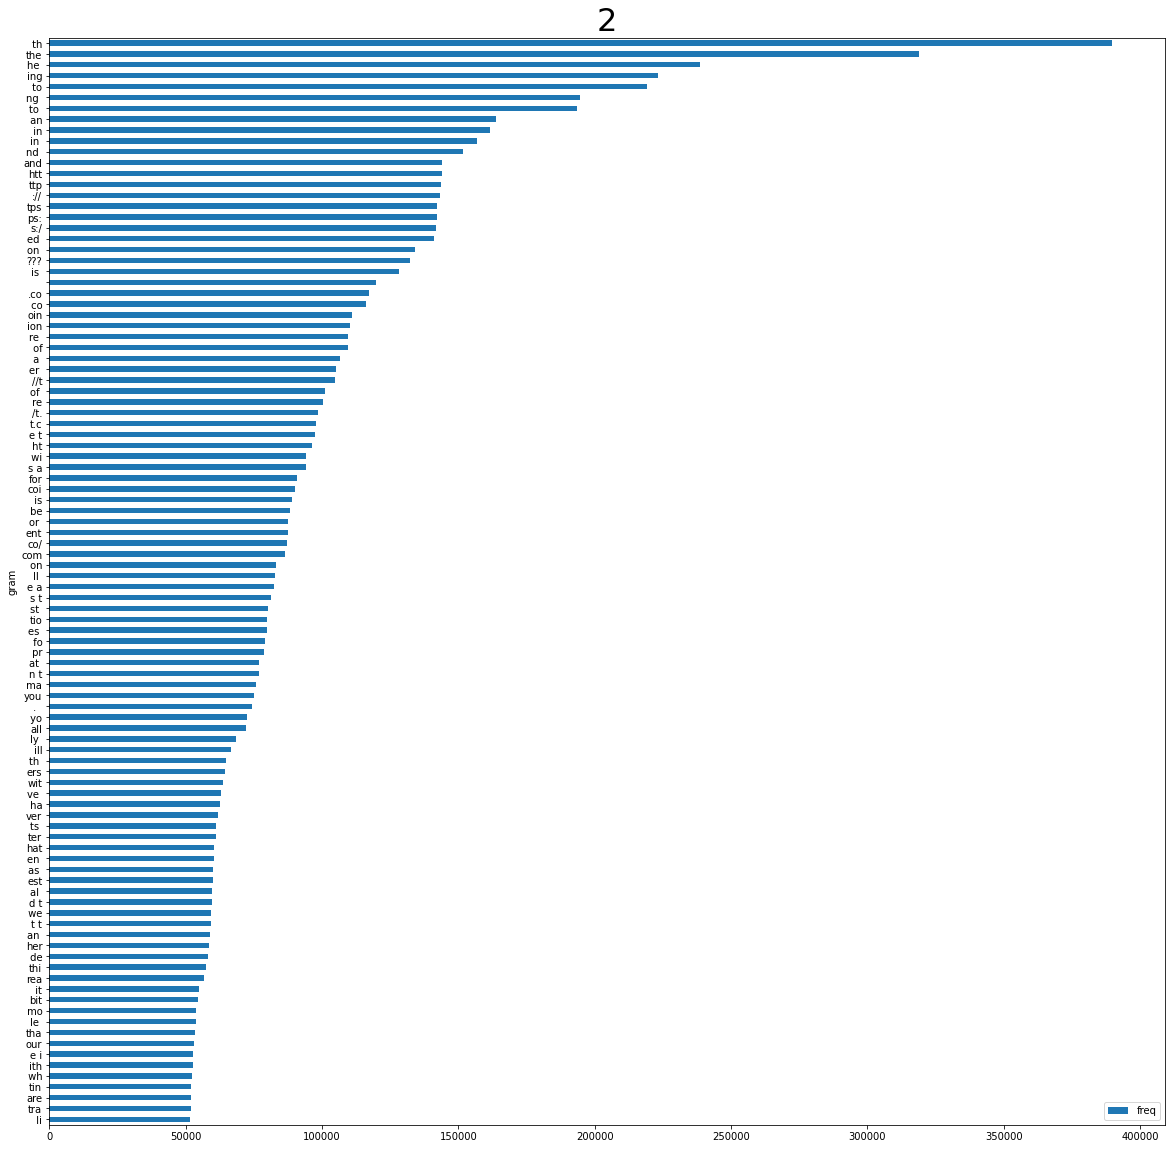

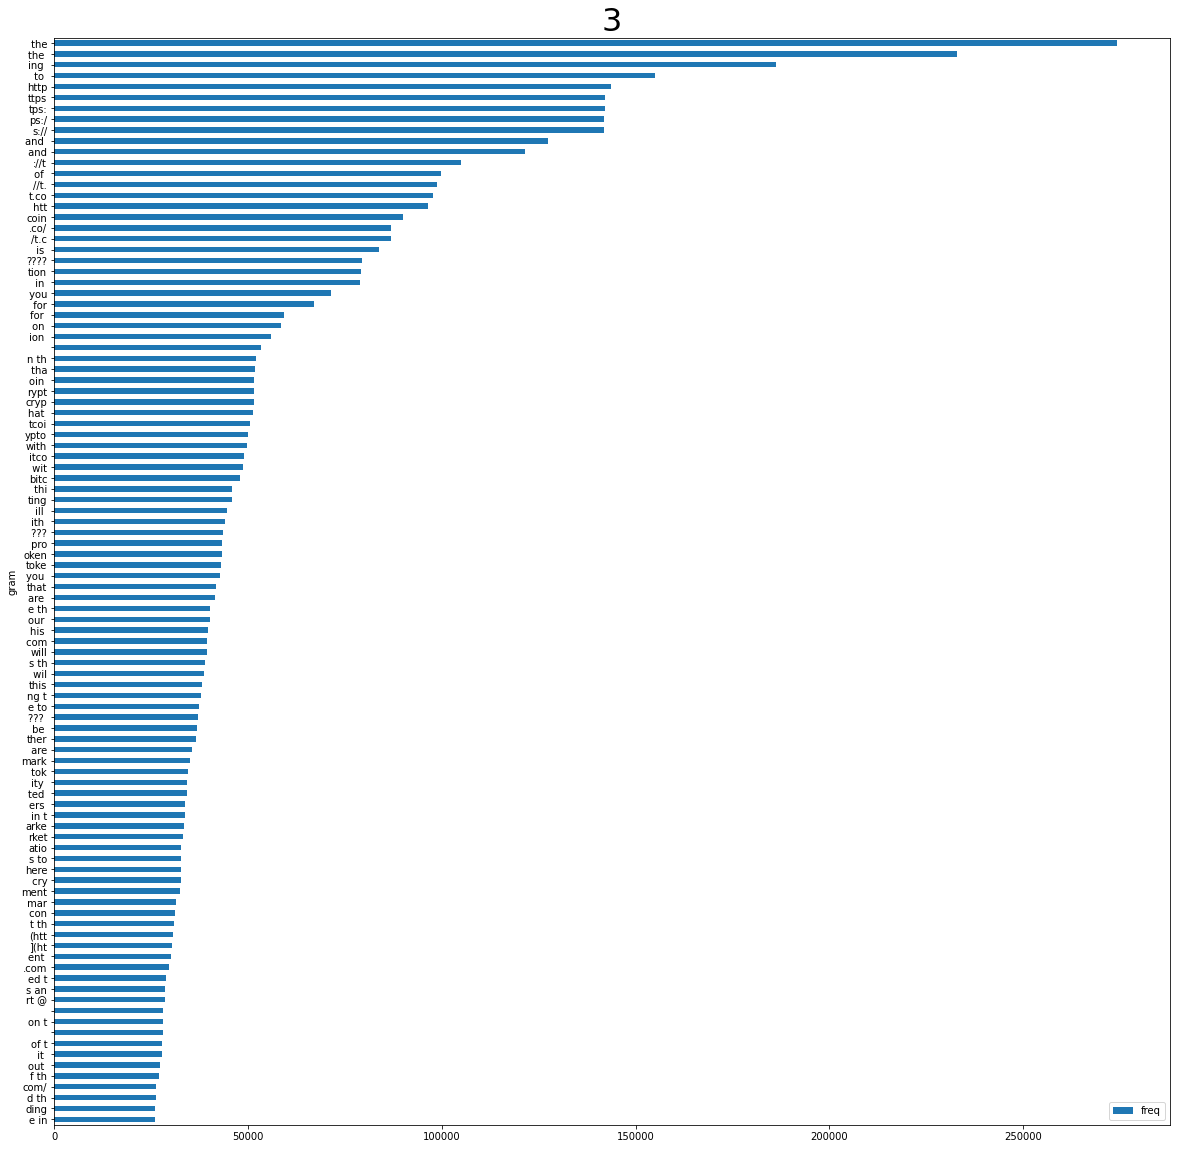

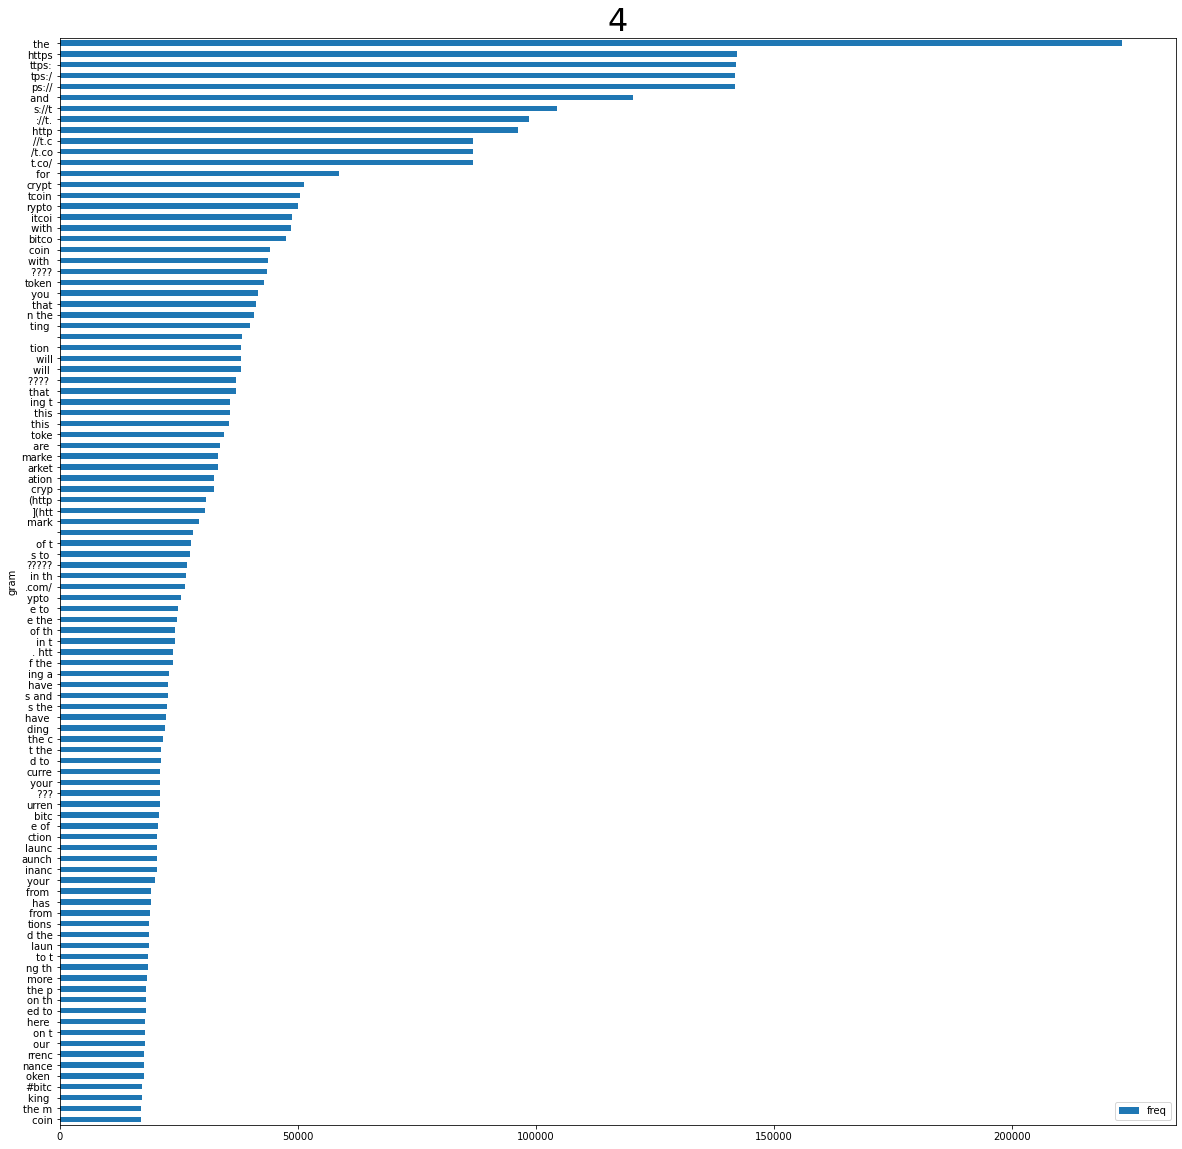

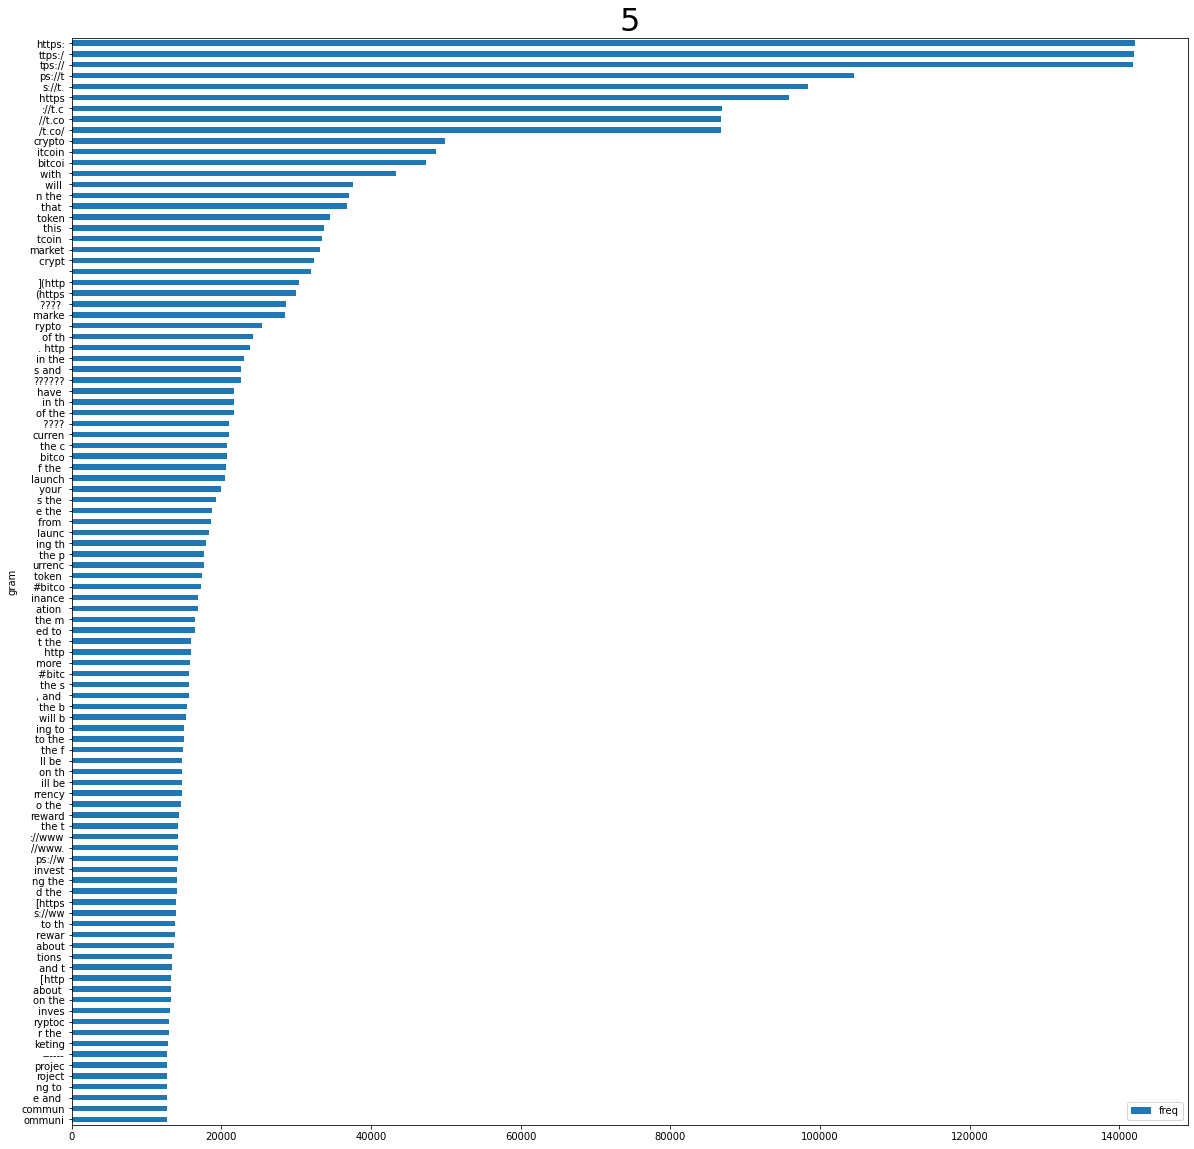

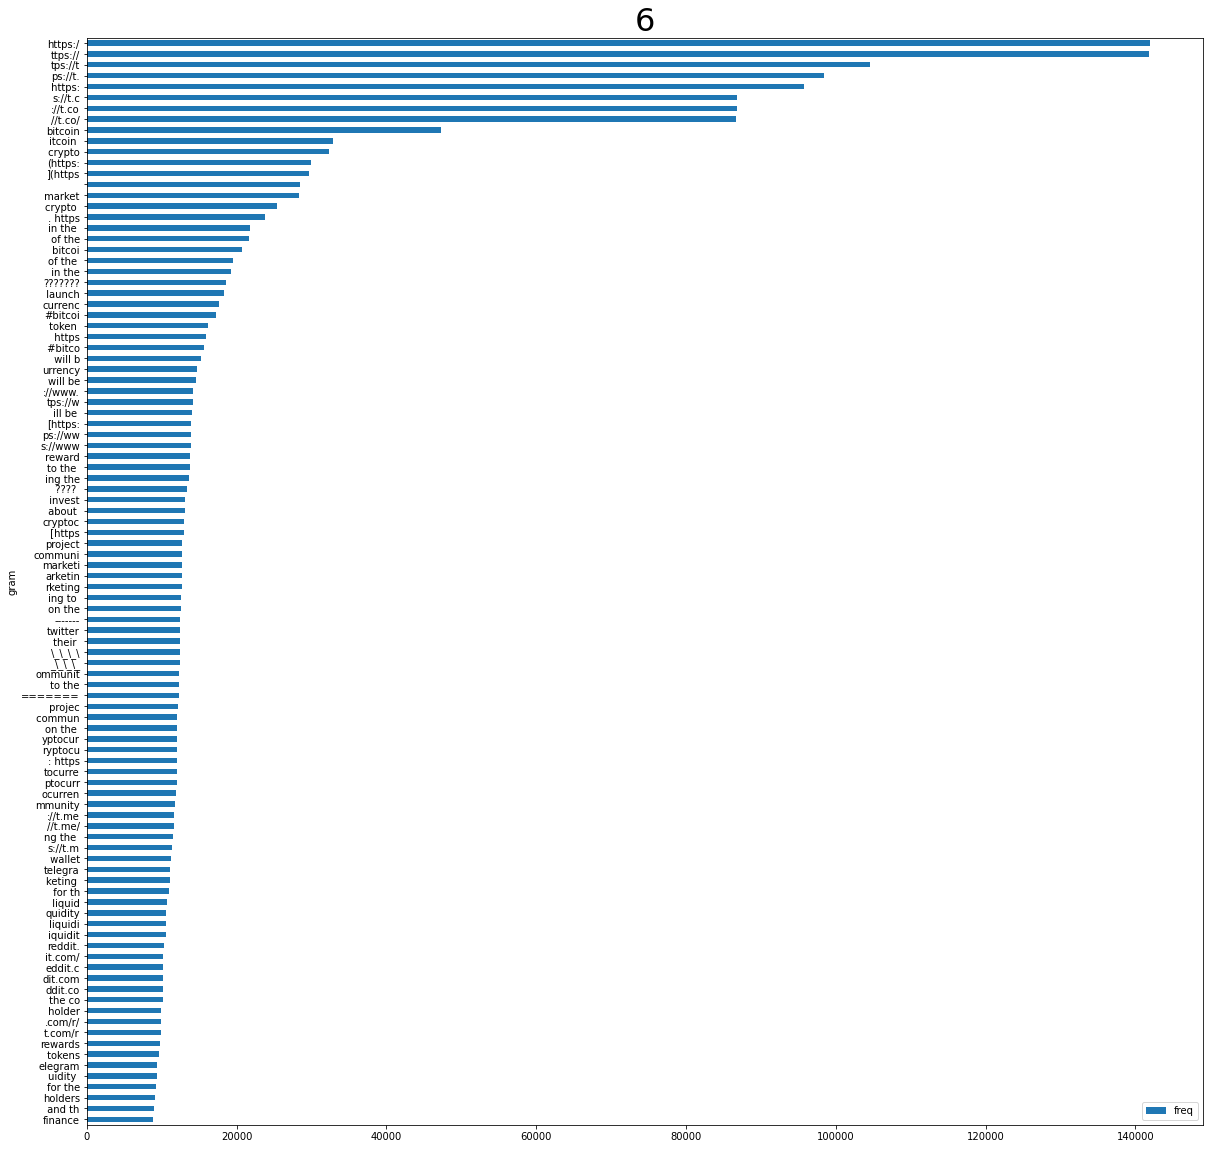

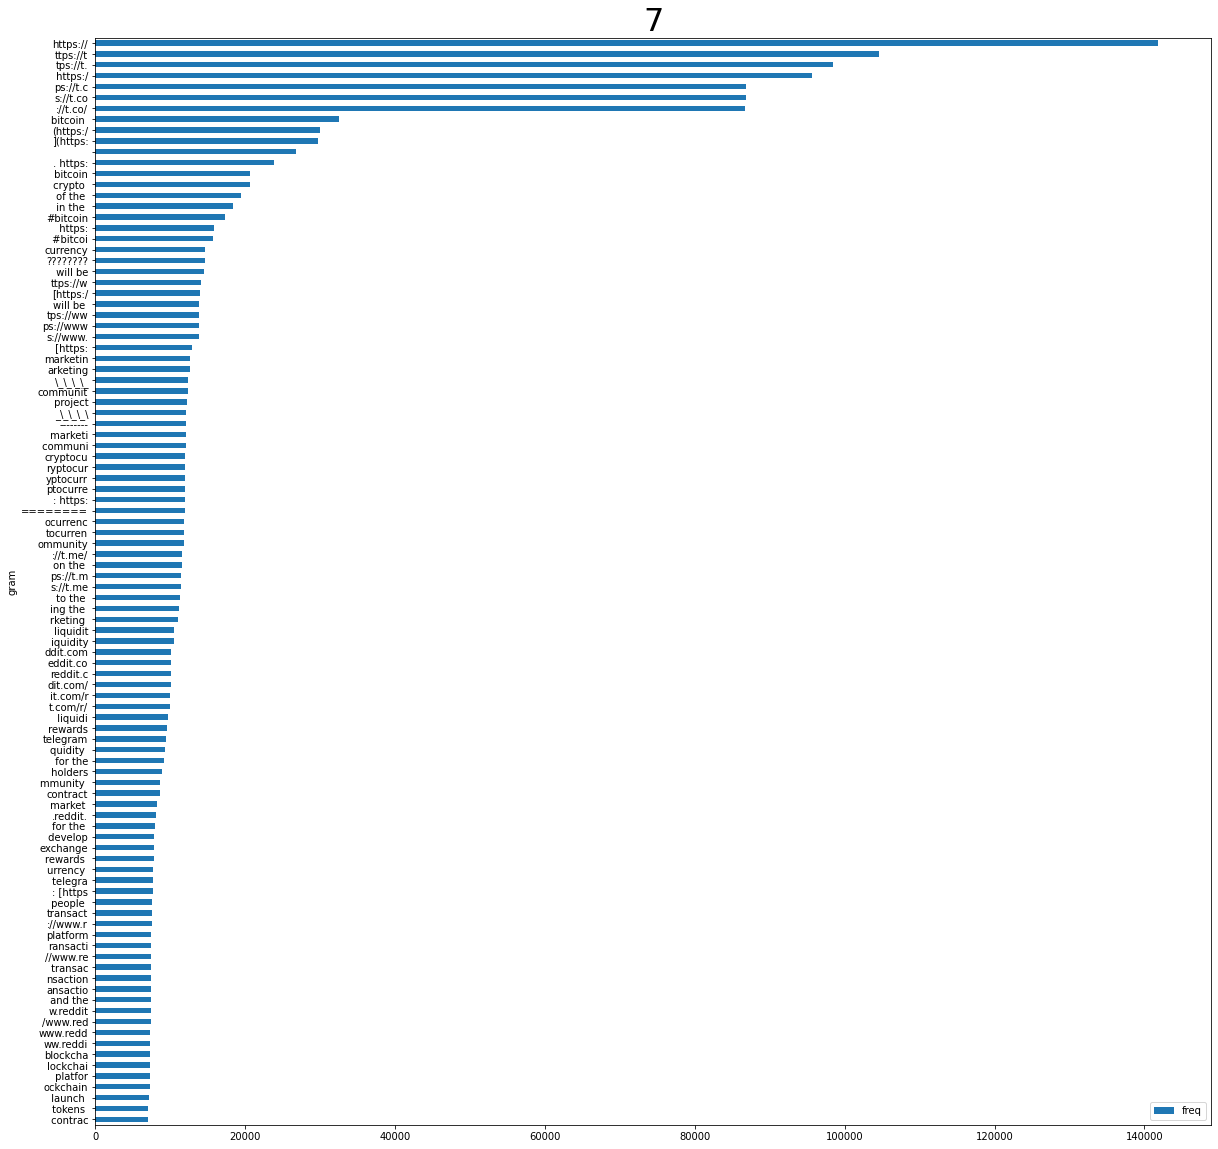

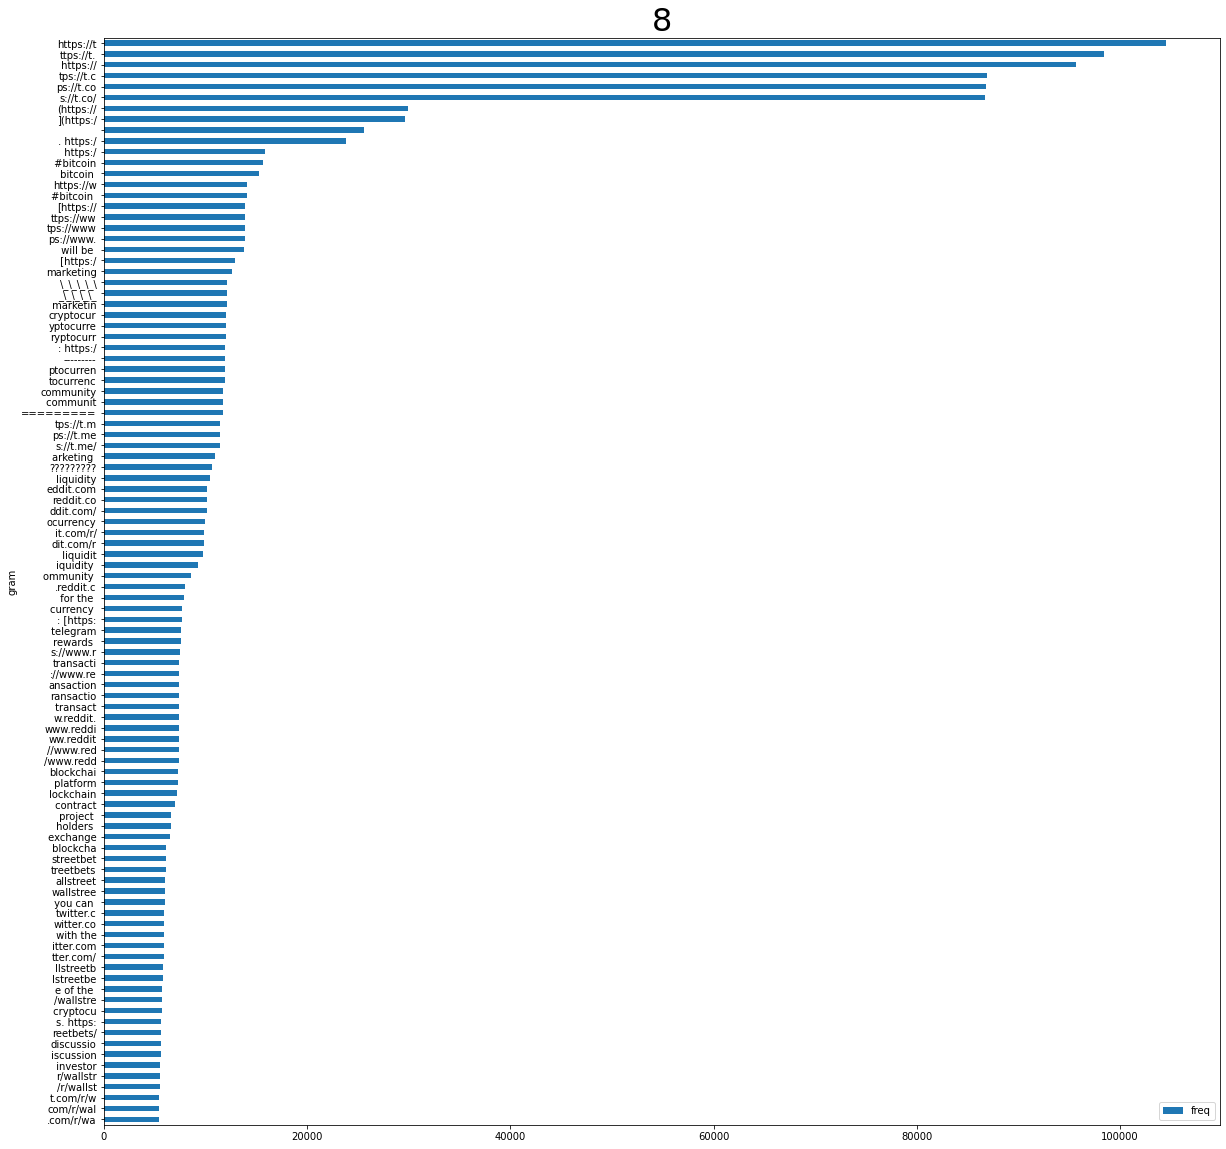

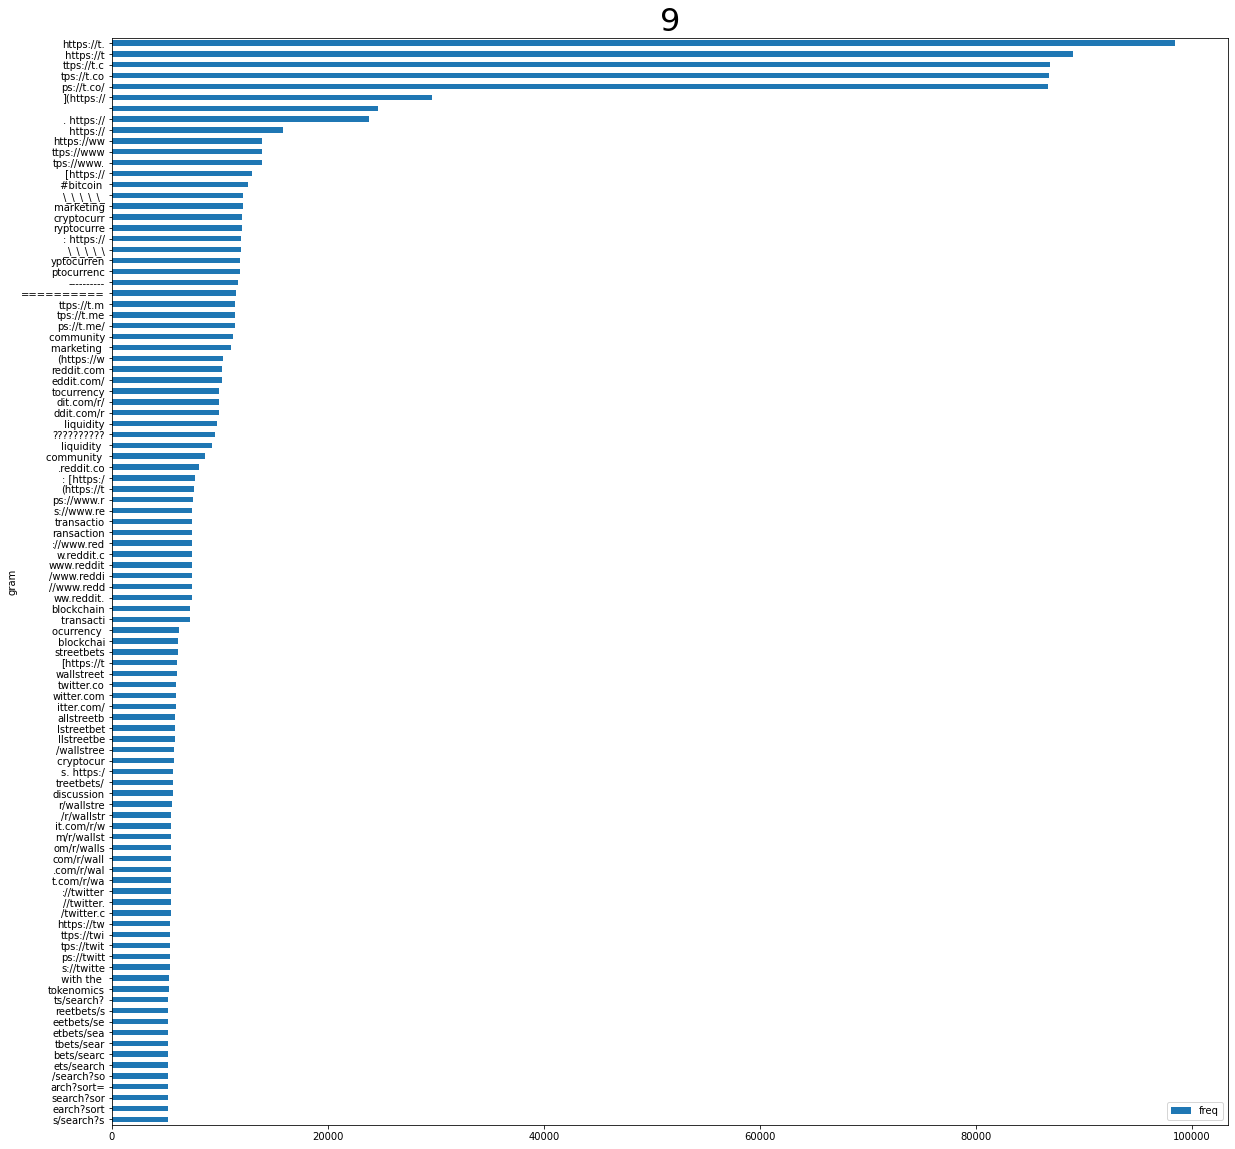

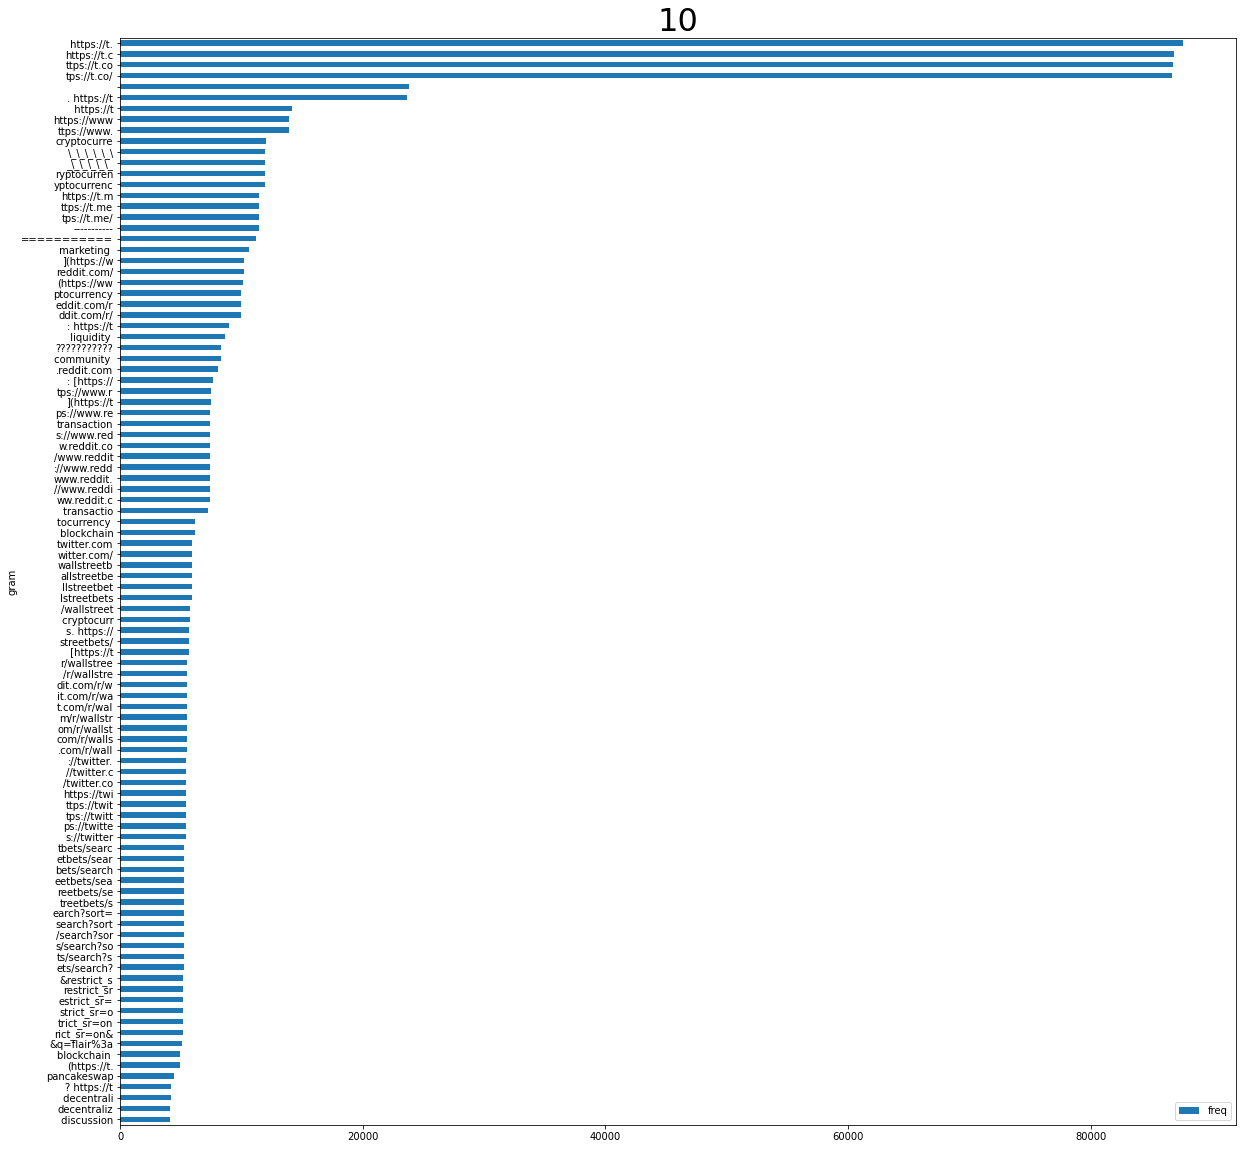

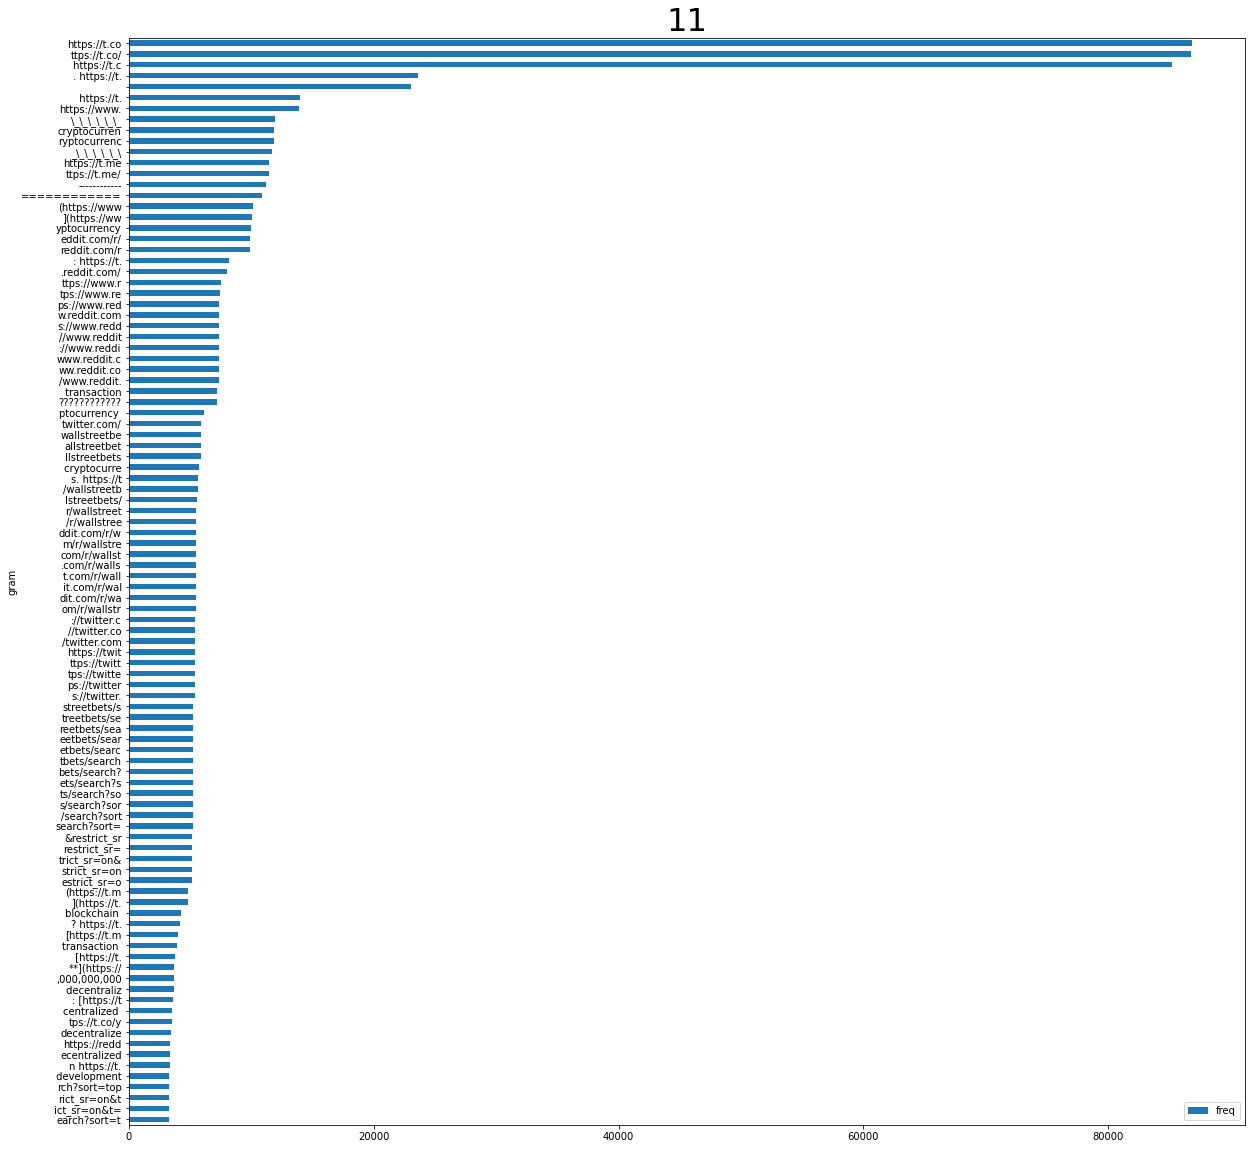

In [42]:
plt.rcParams["figure.figsize"] = (20,20)
for df in dfs:
    p = df[:100][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();
    p.set_title(df.title,fontsize = 32)
    plt.show()
    

In [43]:
all_counters1 = {}
for counter in counters1:
    all_counters1 = merge_two_dicts(all_counters1,counter)

In [45]:
print(all_counters1[' liquidity'])
print(all_counters1['liquidity '])
print(all_counters1['iquidity '])
print(all_counters1['liquidity'])
print(all_counters1['iquidity '])
print(all_counters1['iquidity.'])


9744
9254
9255
10515
9255
250


In [46]:
all_df = pd.DataFrame([(gram, all_counters1[gram]) for gram in all_counters1],columns=['gram','freq'])
all_df['log'] = np.log10(all_df['freq'])
all_df.sort_values('freq',ascending=False,inplace=True)
all_df

,gram,freq,log
2,,6329755,6.801387
11,e,3311340,6.520004
1,t,3050884,6.484426
20,o,2419007,6.383637
5,a,2332210,6.367768
...,...,...,...
38540455,ptodr: whe,1,0.000000
38540456,todr: wher,1,0.000000
38540457,odr: where,1,0.000000
38540458,dr: where,1,0.000000


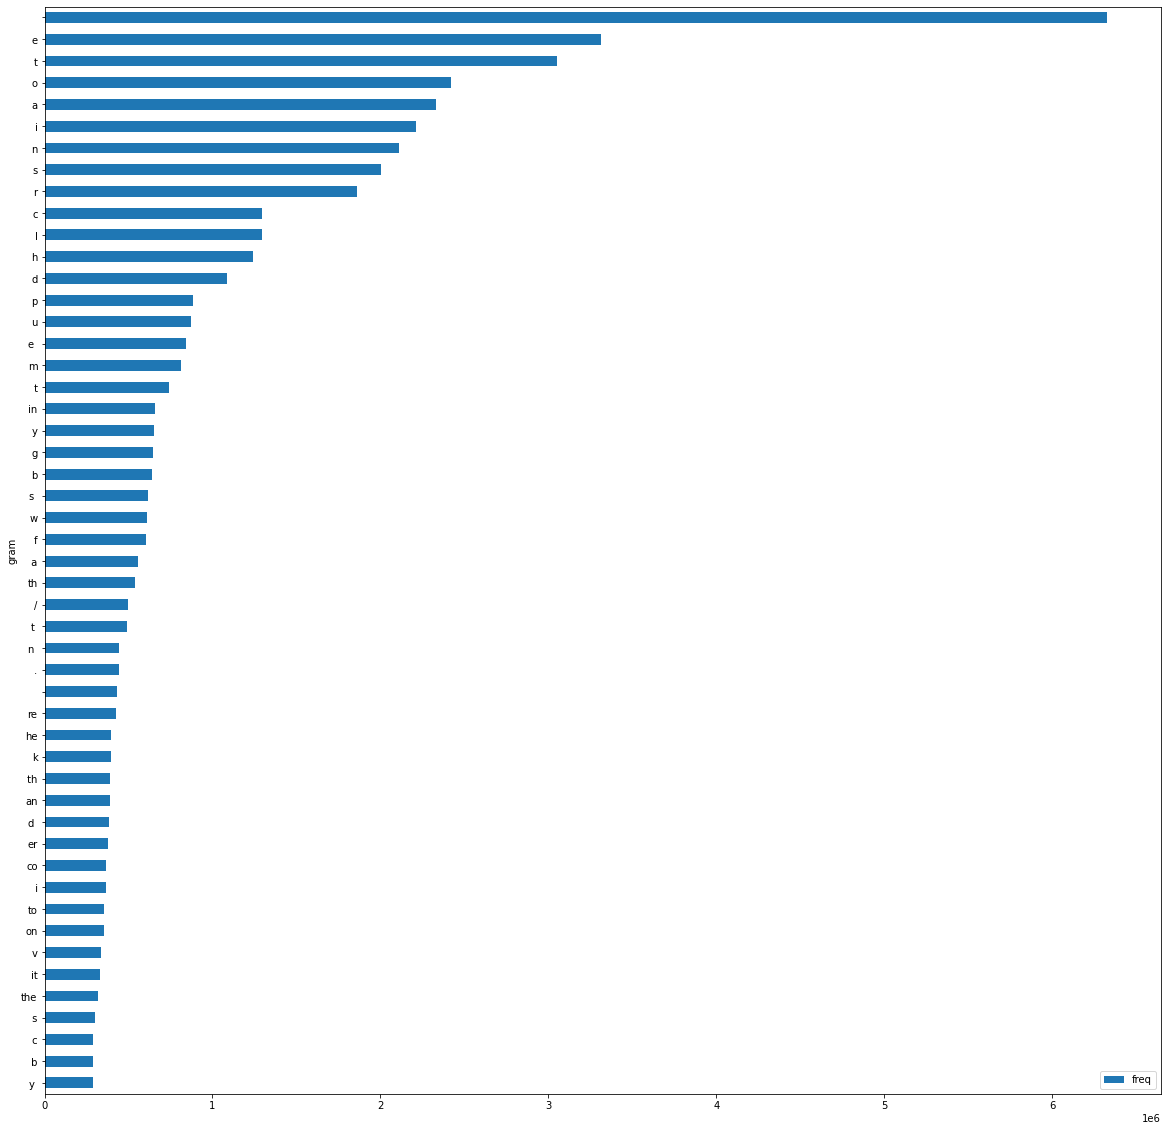

In [47]:
p = all_df[:50][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


In [48]:
all_counters1['_']

65857

In [49]:
def tokenize_with_lexicon(alphalex,text):
    alex = list(alphalex) #TODO precompile
    alex.sort(key=len,reverse=True)
    tokens = []
    start = 0
    cur = 0
    length = len(text)
    while cur < length:
        subtext = text[cur:]
        #print(subtext)
        for al in alex:
            matched = False
            if subtext.startswith(al):
                if start < cur:
                    tokens.append(text[start:cur])
                tokens.append(al)
                cur += len(al)
                start = cur
                matched = True
                break
        if not matched:
            cur += 1
                
    if start < cur:
        tokens.append(text[start:cur])
    return tokens


In [50]:
lexicon = {'a','xyz','ij'}
lexlist = list(lexicon)
lexlist.sort(key=len,reverse=True)
lexlist

['xyz', 'ij', 'a']

In [51]:
alphalex = {' ','-','.','!'}
tokenize_with_lexicon(alphalex,"I know-you know. We know!")

['I', ' ', 'know', '-', 'you', ' ', 'know', '.', ' ', 'We', ' ', 'know', '!']

In [52]:
counters2 = grams_init(max_n)
alphalex = {' '}

all_tokens = {}

for text in feeds_df['text']:
    text = preprocess_text(text)
    tokens = tokenize_with_lexicon(alphalex,text)
    for token in tokens:
        if not token in alphalex: #skip known tokens 
            text_grams_count(counters2,token,max_n)
        count(all_tokens,token)


In [53]:
token_df = pd.DataFrame([(gram, all_tokens[gram]) for gram in all_tokens],columns=['gram','freq'])
token_df['log'] = np.log10(token_df['freq'])
token_df.sort_values('freq',ascending=False,inplace=True)

367689


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


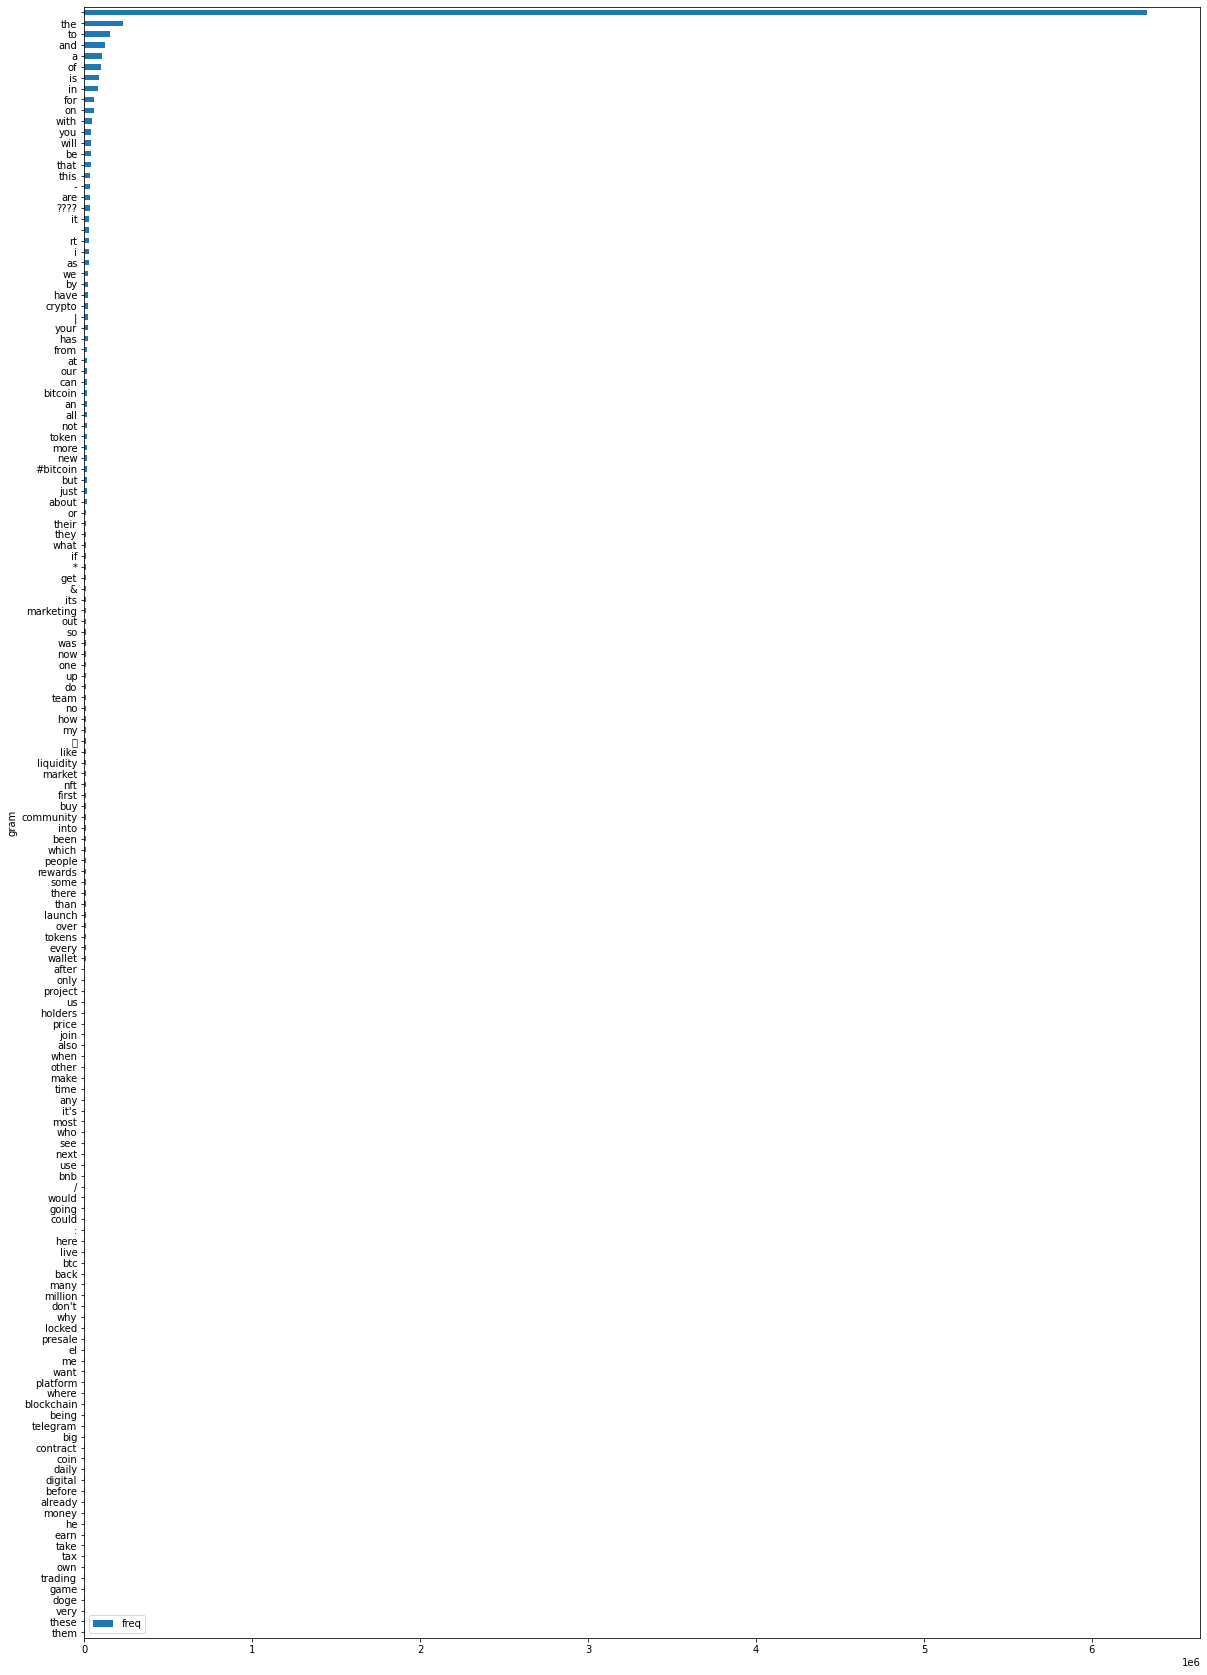

In [54]:
plt.rcParams["figure.figsize"] = (20,30)
print(len(token_df))
p = token_df[:150][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


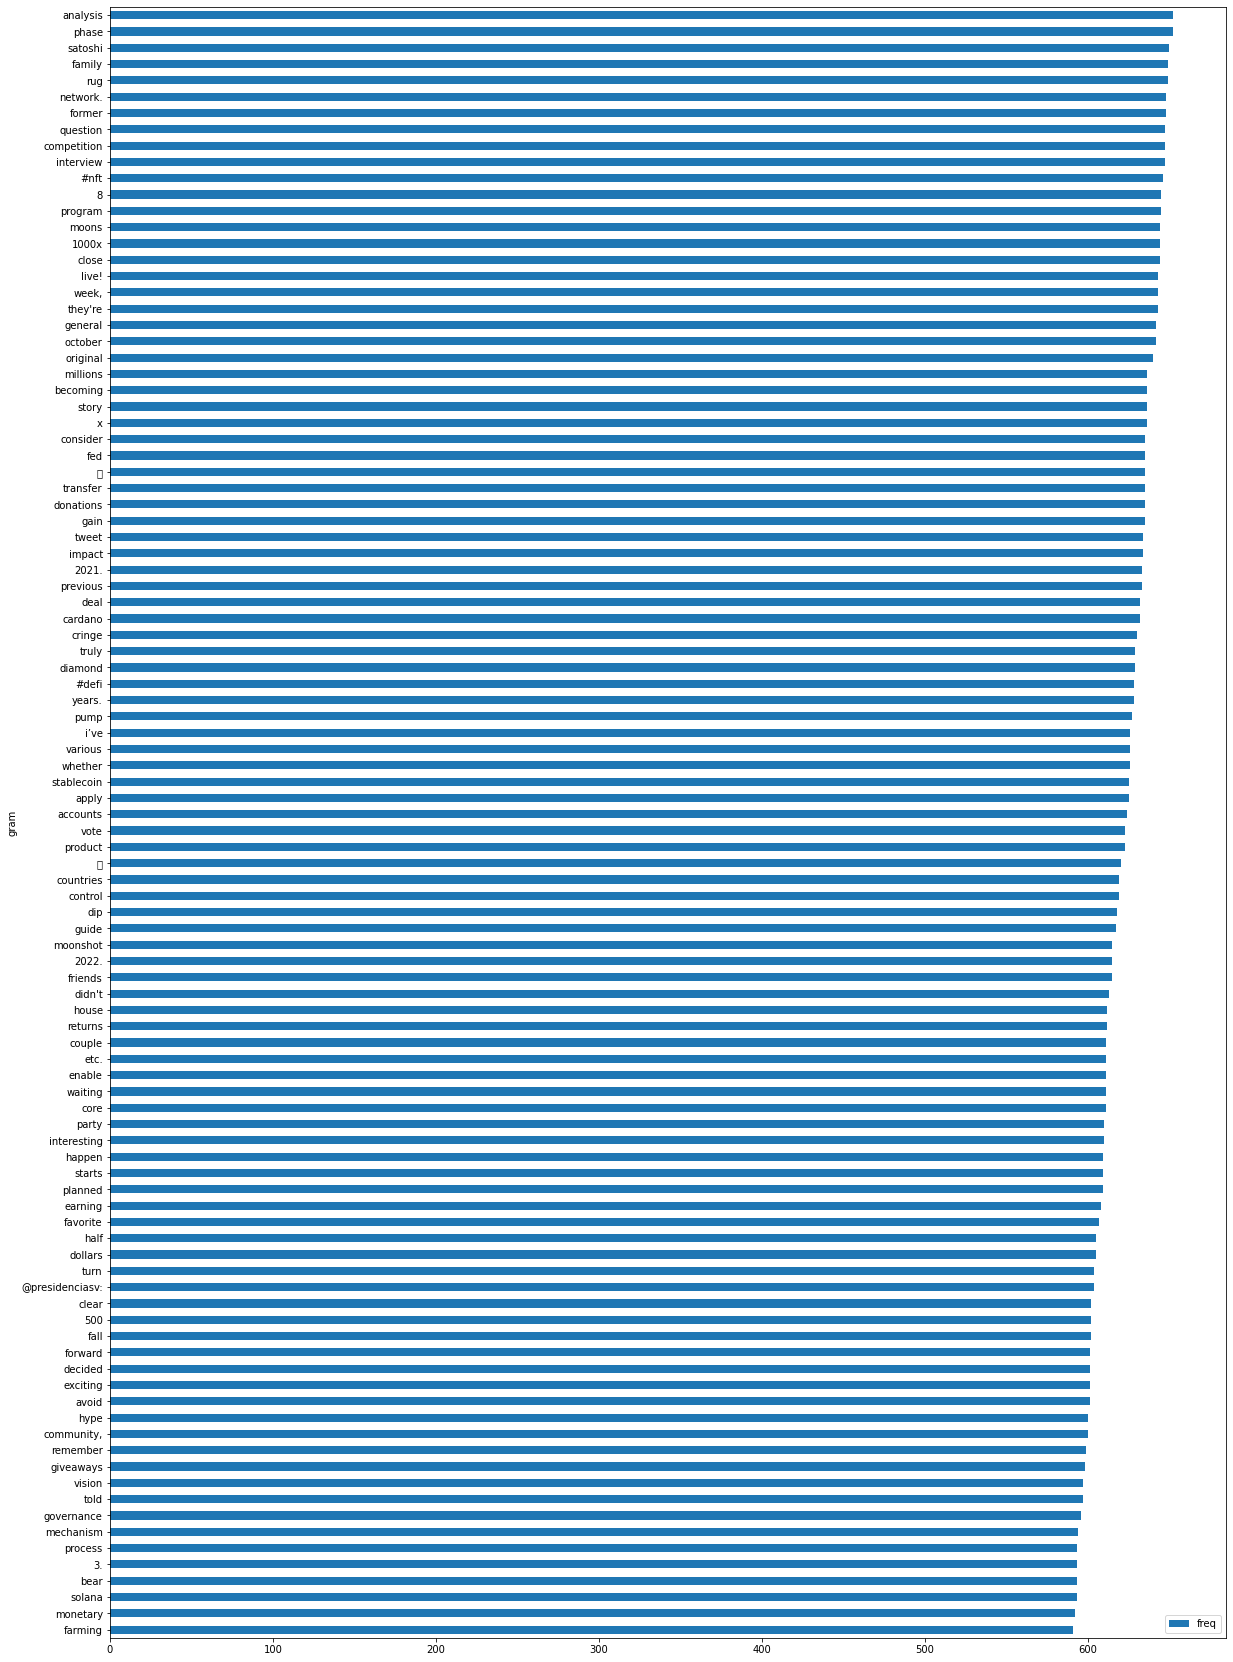

In [55]:
#367689
plt.rcParams["figure.figsize"] = (20,30)
p = token_df[1000:1100][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


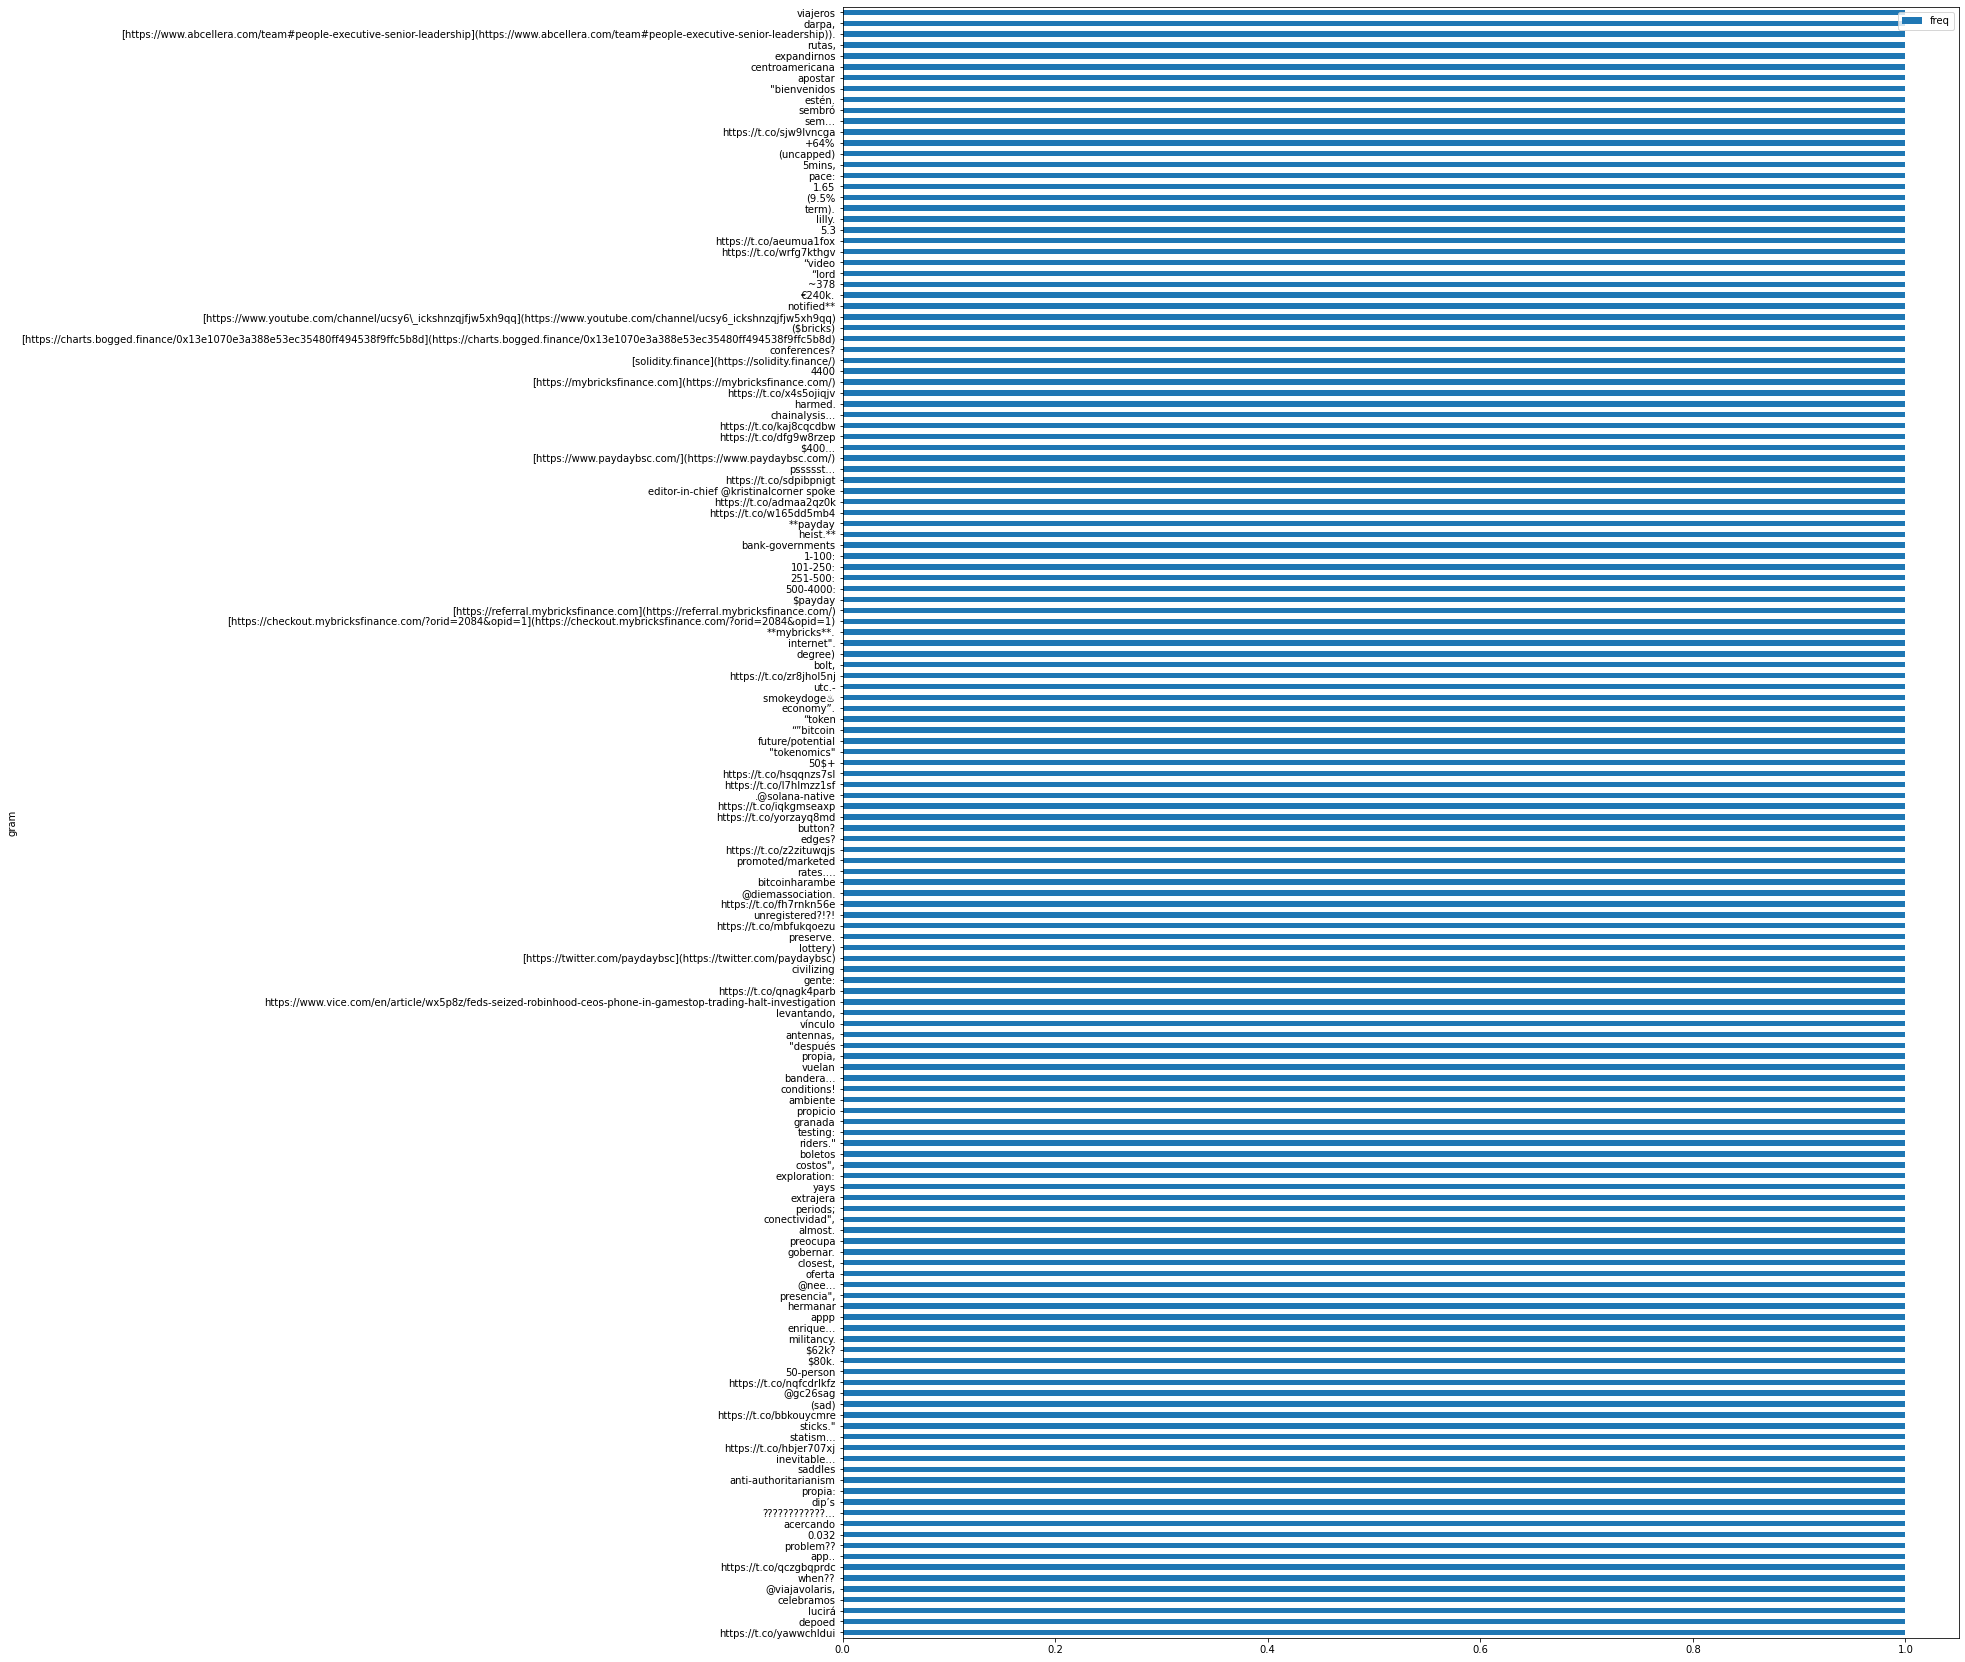

In [56]:
plt.rcParams["figure.figsize"] = (20,30)
p = token_df[-150:][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


In [57]:
dfs = []
for i in range(len(counters2)):
    counter = counters2[i]
    df = pd.DataFrame([(gram, counter[gram]) for gram in counter],columns=['gram','freq'])
    df['log'] = np.log10(df['freq'])
    df.sort_values('freq',ascending=False,inplace=True)
    df.title = str(i)
    dfs.append(df)

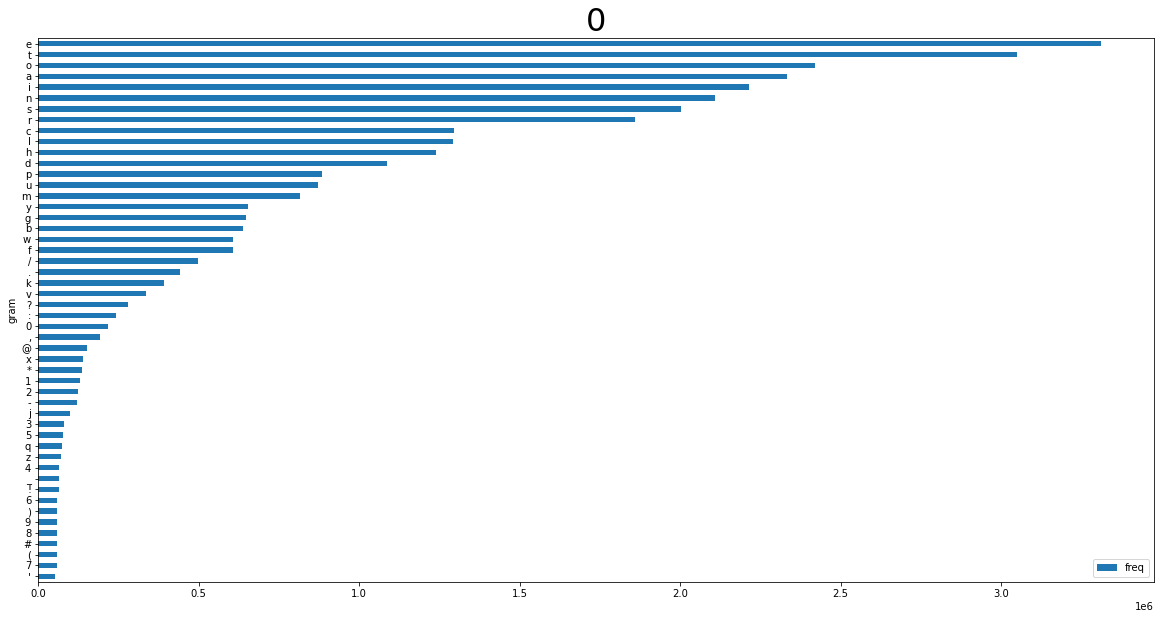

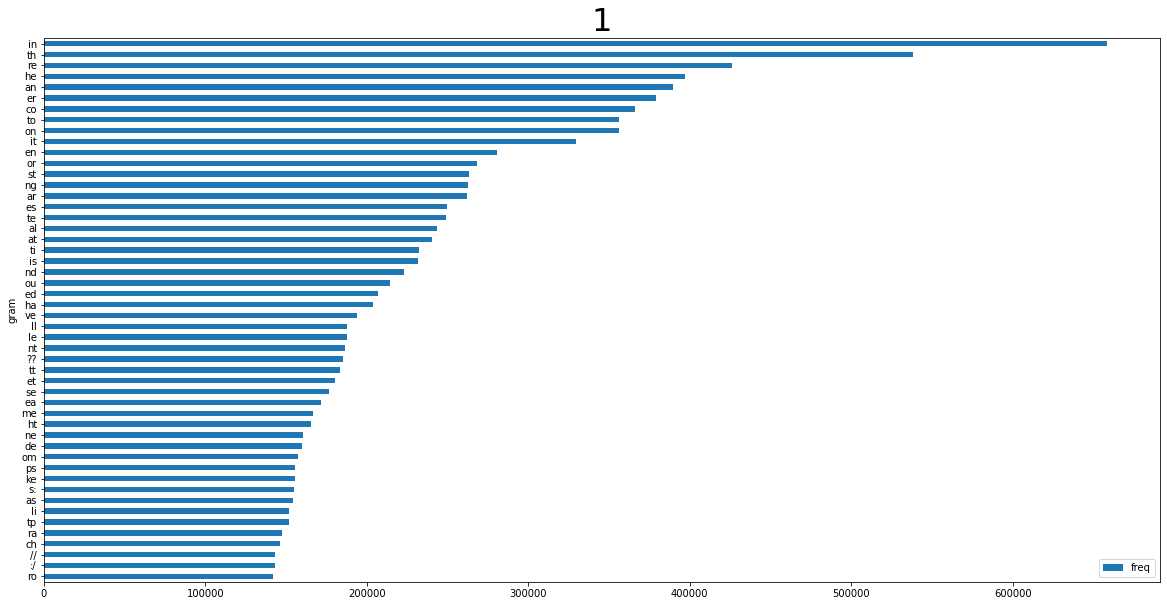

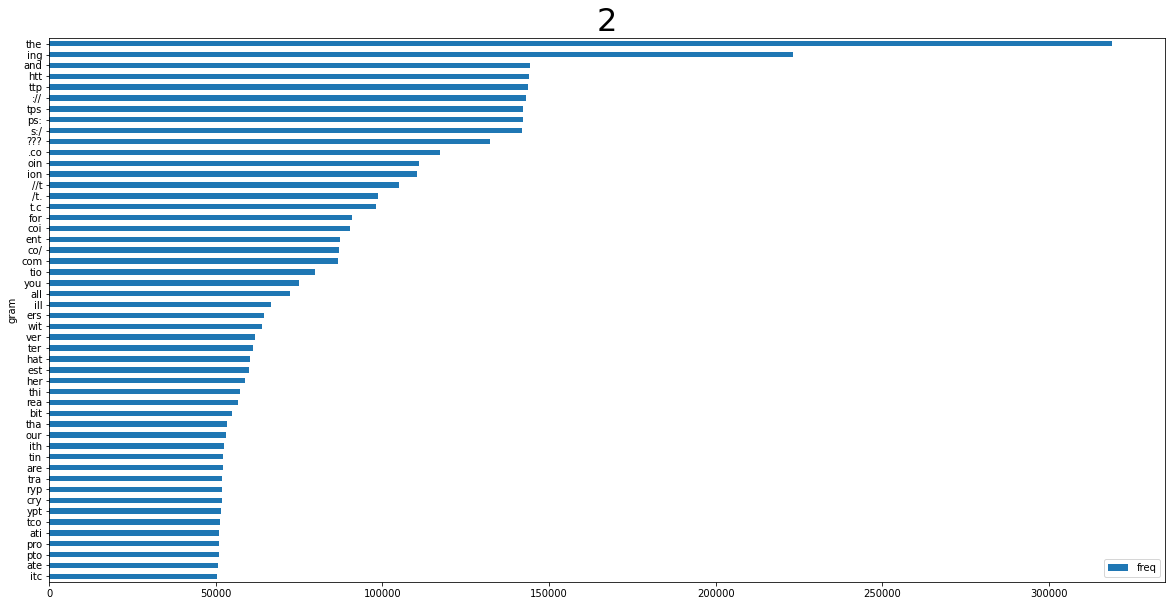

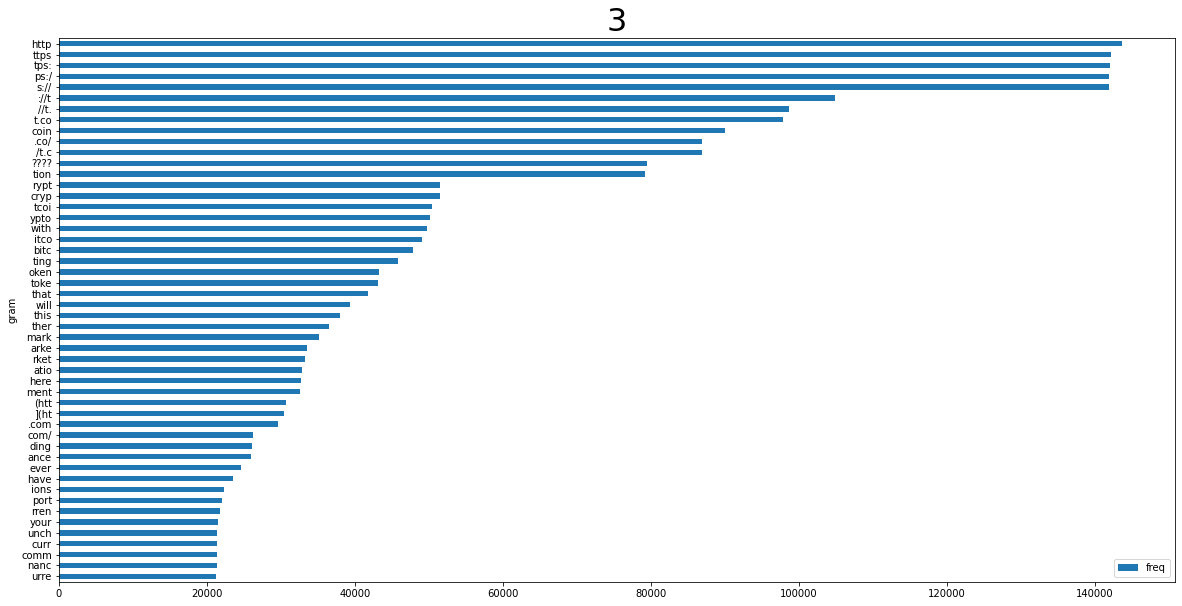

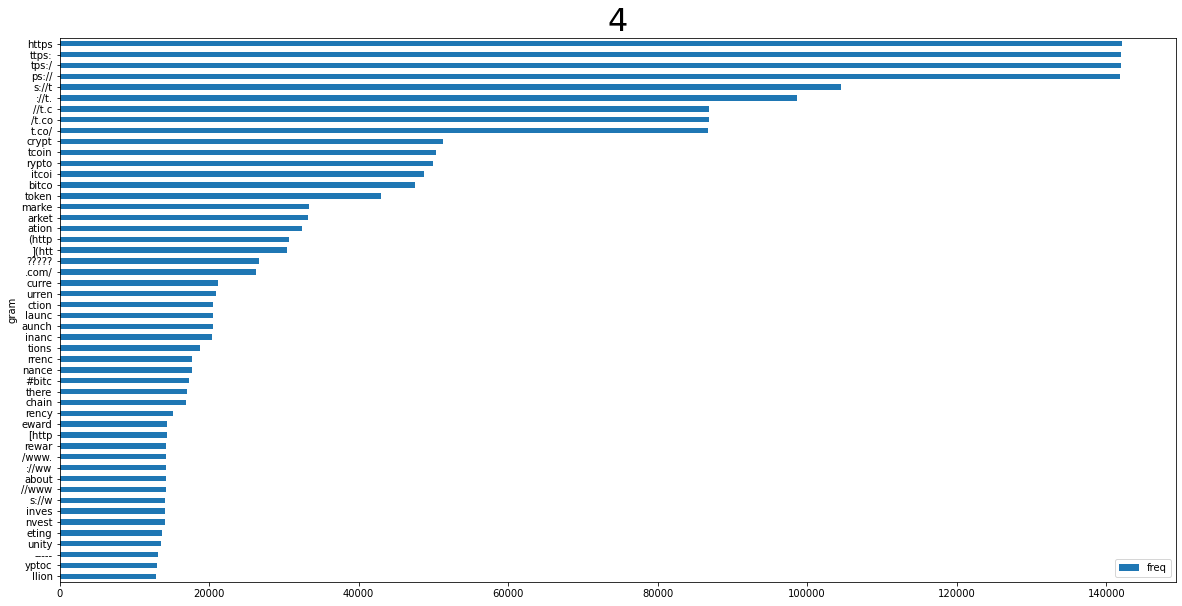

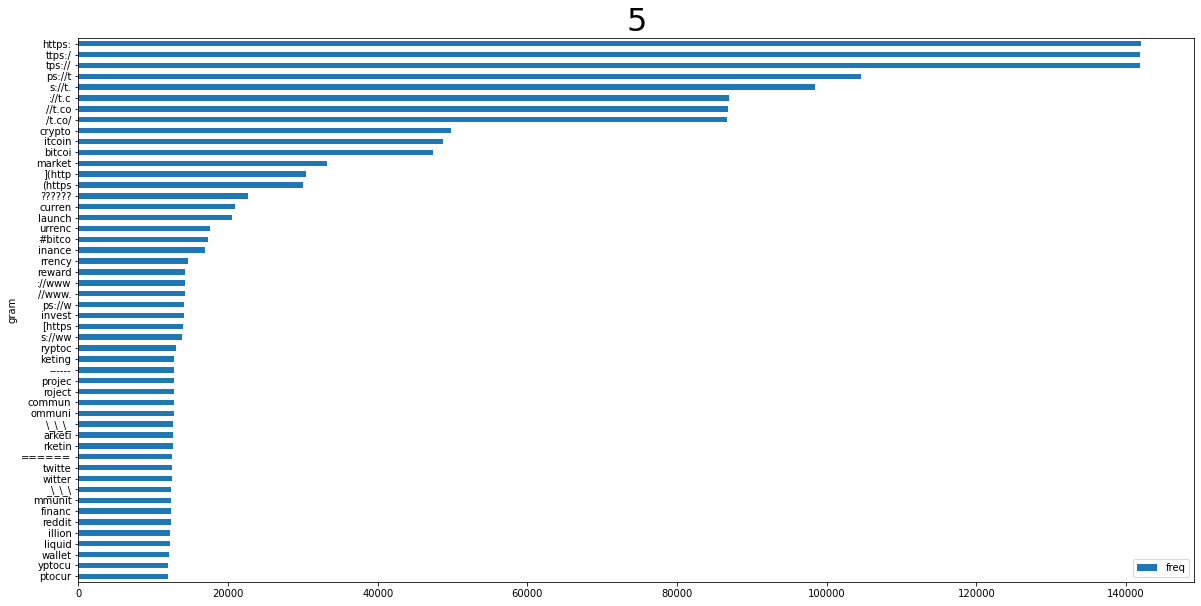

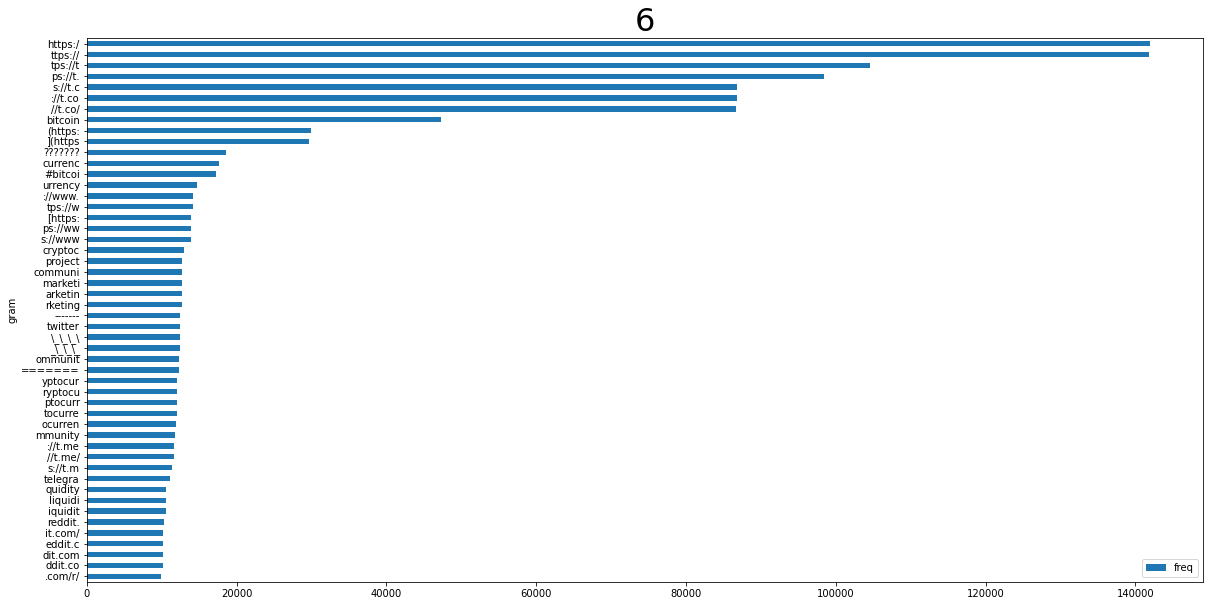

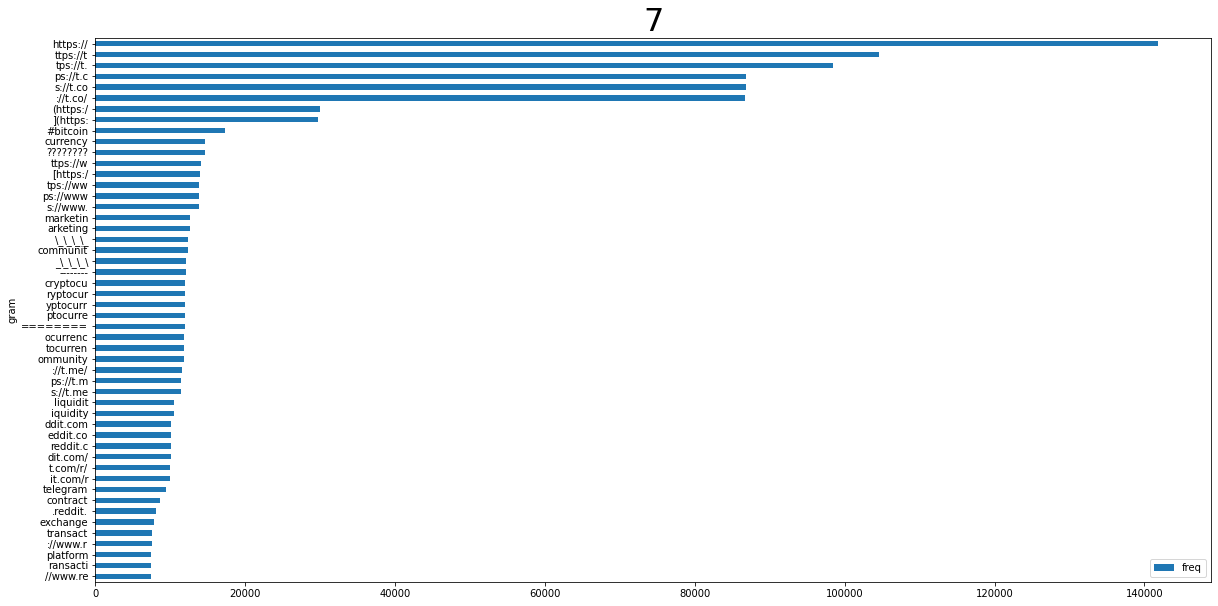

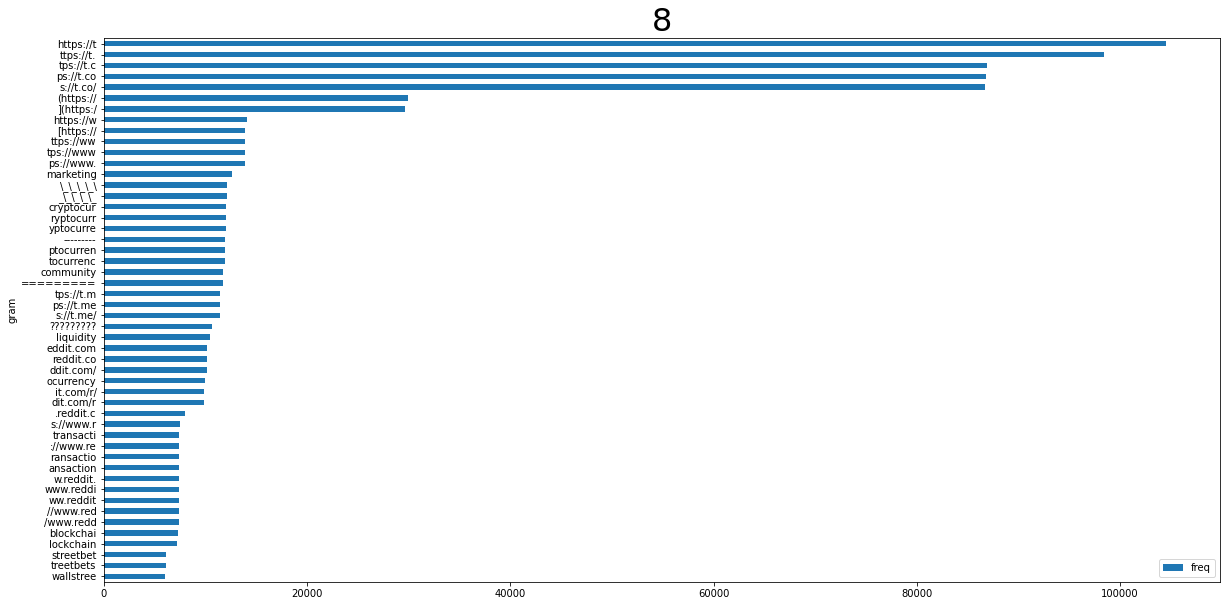

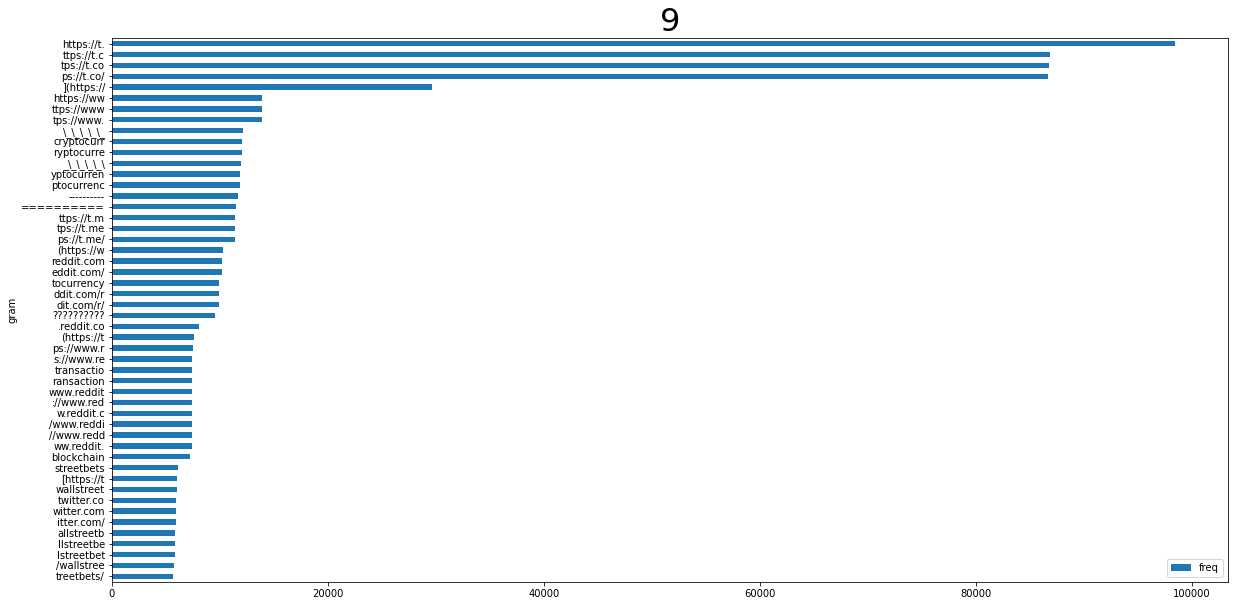

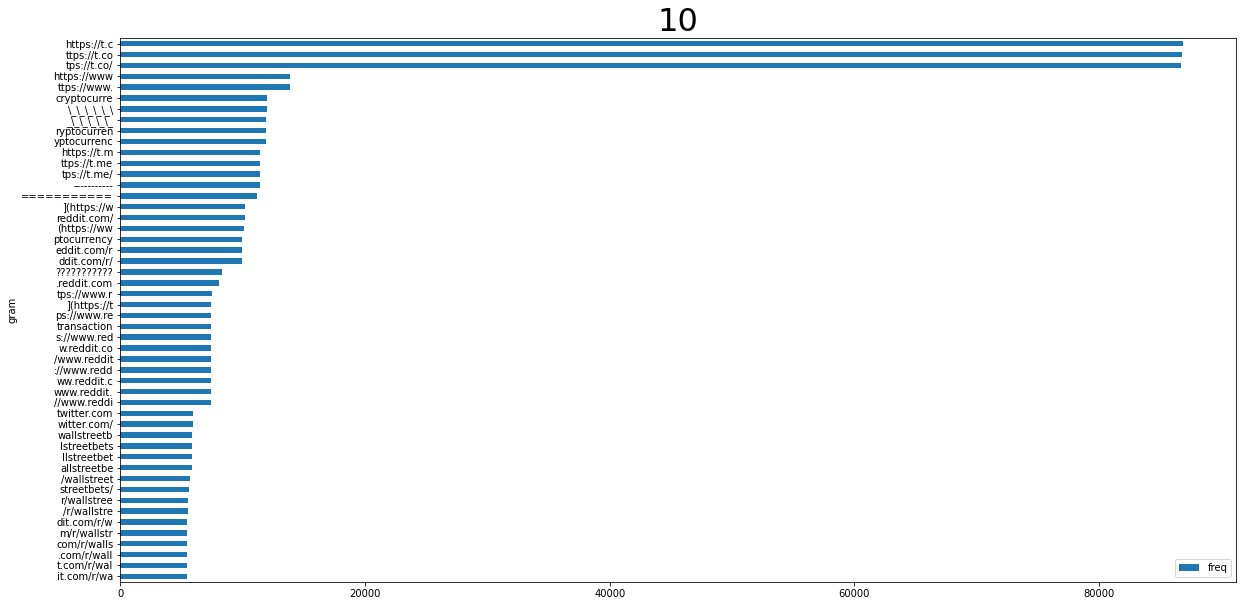

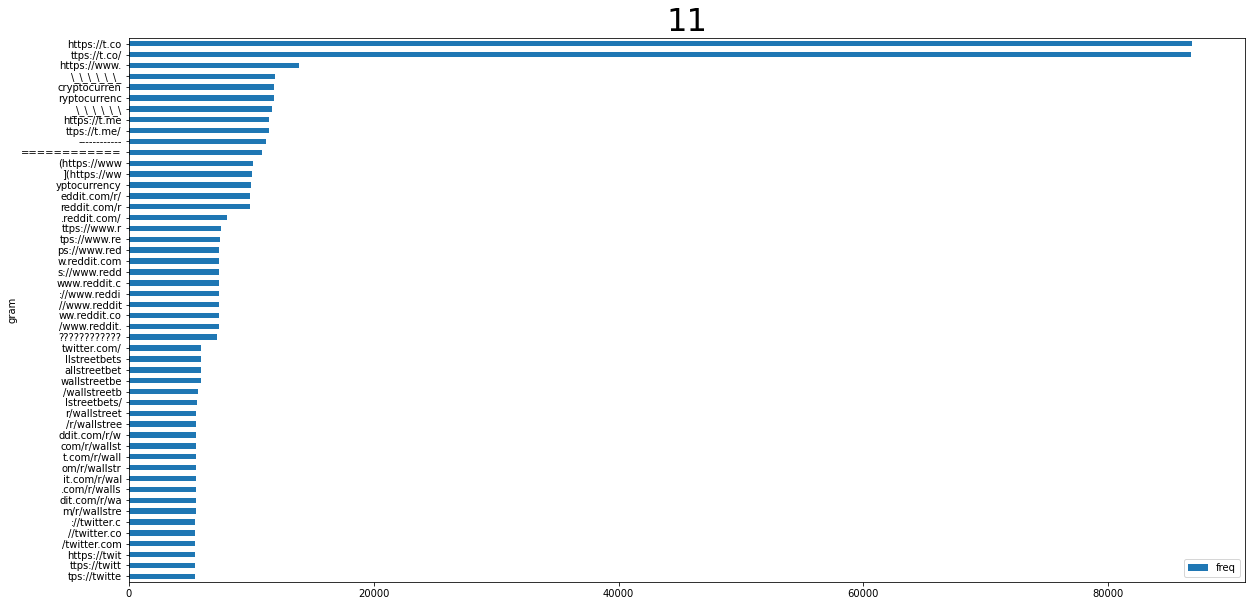

In [58]:
plt.rcParams["figure.figsize"] = (20,10)
for df in dfs:
    p = df[:50][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();
    p.set_title(df.title,fontsize = 32)
    plt.show()


In [59]:
all_counters2 = {}
for counter in counters2:
    all_counters2 = merge_two_dicts(all_counters2,counter)


In [60]:
all_df = pd.DataFrame([(gram, all_counters2[gram]) for gram in all_counters2],columns=['gram','freq'])
all_df['log'] = np.log10(all_df['freq'])
all_df.sort_values('freq',ascending=False,inplace=True)
all_df


,gram,freq,log
10,e,3311340,6.520004
1,t,3050884,6.484426
19,o,2419007,6.383637
4,a,2332210,6.367768
13,i,2214966,6.345367
...,...,...,...
4953087,.co/ubtt,1,0.000000
798293,rrtj,1,0.000000
798294,rtjn,1,0.000000
798295,tjnk,1,0.000000


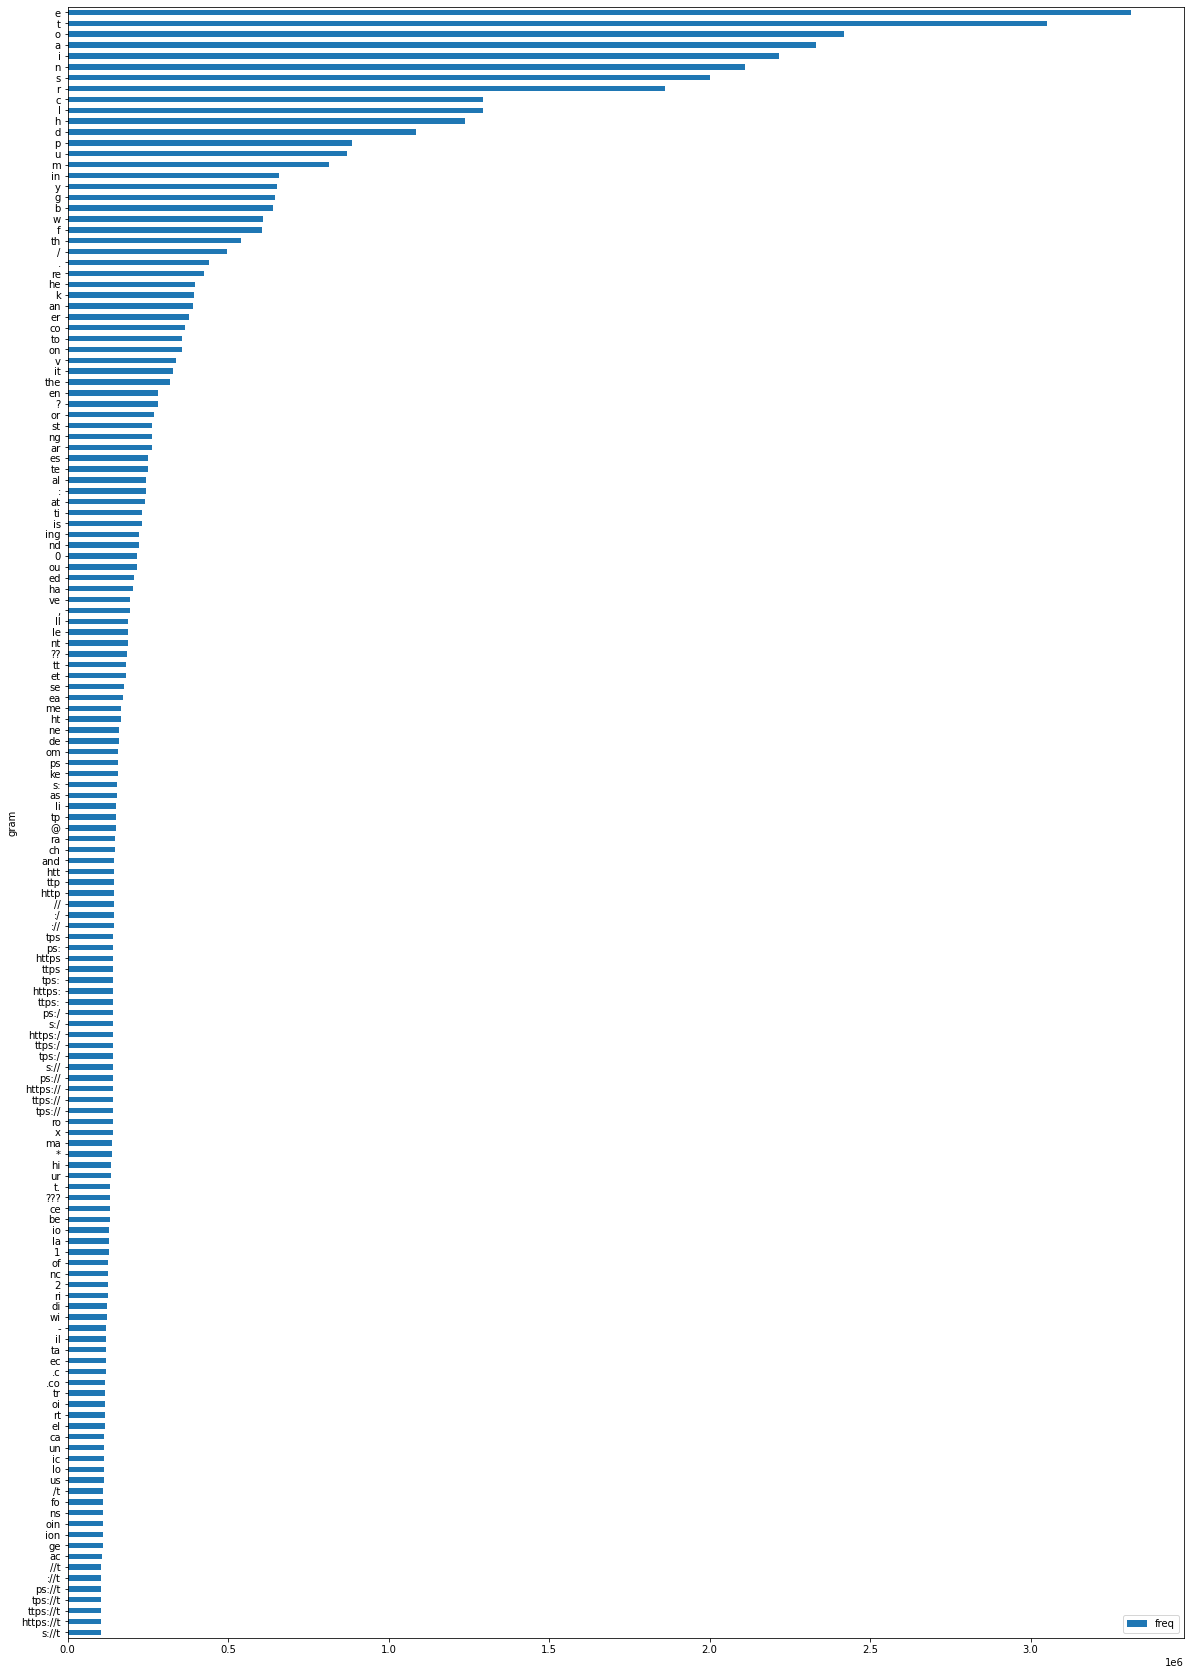

In [61]:
plt.rcParams["figure.figsize"] = (20,30)
p = all_df[:150][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


In [62]:
set(list(token_df[:100]['gram']))

{' ',
 '#bitcoin',
 '&',
 '*',
 '-',
 '????',
 'a',
 'about',
 'after',
 'all',
 'also',
 'an',
 'and',
 'are',
 'as',
 'at',
 'be',
 'been',
 'bitcoin',
 'but',
 'buy',
 'by',
 'can',
 'community',
 'crypto',
 'do',
 'every',
 'first',
 'for',
 'from',
 'get',
 'has',
 'have',
 'holders',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'it',
 'its',
 'join',
 'just',
 'launch',
 'like',
 'liquidity',
 'make',
 'market',
 'marketing',
 'more',
 'my',
 'new',
 'nft',
 'no',
 'not',
 'now',
 'of',
 'on',
 'one',
 'only',
 'or',
 'other',
 'our',
 'out',
 'over',
 'people',
 'price',
 'project',
 'rewards',
 'rt',
 'so',
 'some',
 'team',
 'than',
 'that',
 'the',
 'their',
 'there',
 'they',
 'this',
 'time',
 'to',
 'token',
 'tokens',
 'up',
 'us',
 'wallet',
 'was',
 'we',
 'what',
 'when',
 'which',
 'will',
 'with',
 'you',
 'your',
 '|',
 '\u200b',
 '✅'}

In [63]:
#TODO with top 1000 grams
counters3 = grams_init(max_n)
alphalex3 = set(list(token_df[:100]['gram']))

all_tokens3 = {}

for text in feeds_df['text']:
    text = preprocess_text(text)
    tokens = tokenize_with_lexicon(alphalex3,text)
    for token in tokens:
        if not token in alphalex3: #skip known tokens 
            text_grams_count(counters3,token,max_n)
        count(all_tokens3,token)


In [64]:
token3_df = pd.DataFrame([(gram, all_tokens3[gram]) for gram in all_tokens3],columns=['gram','freq'])
token3_df['log'] = np.log10(token3_df['freq'])
token3_df.sort_values('freq',ascending=False,inplace=True)

247415


/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


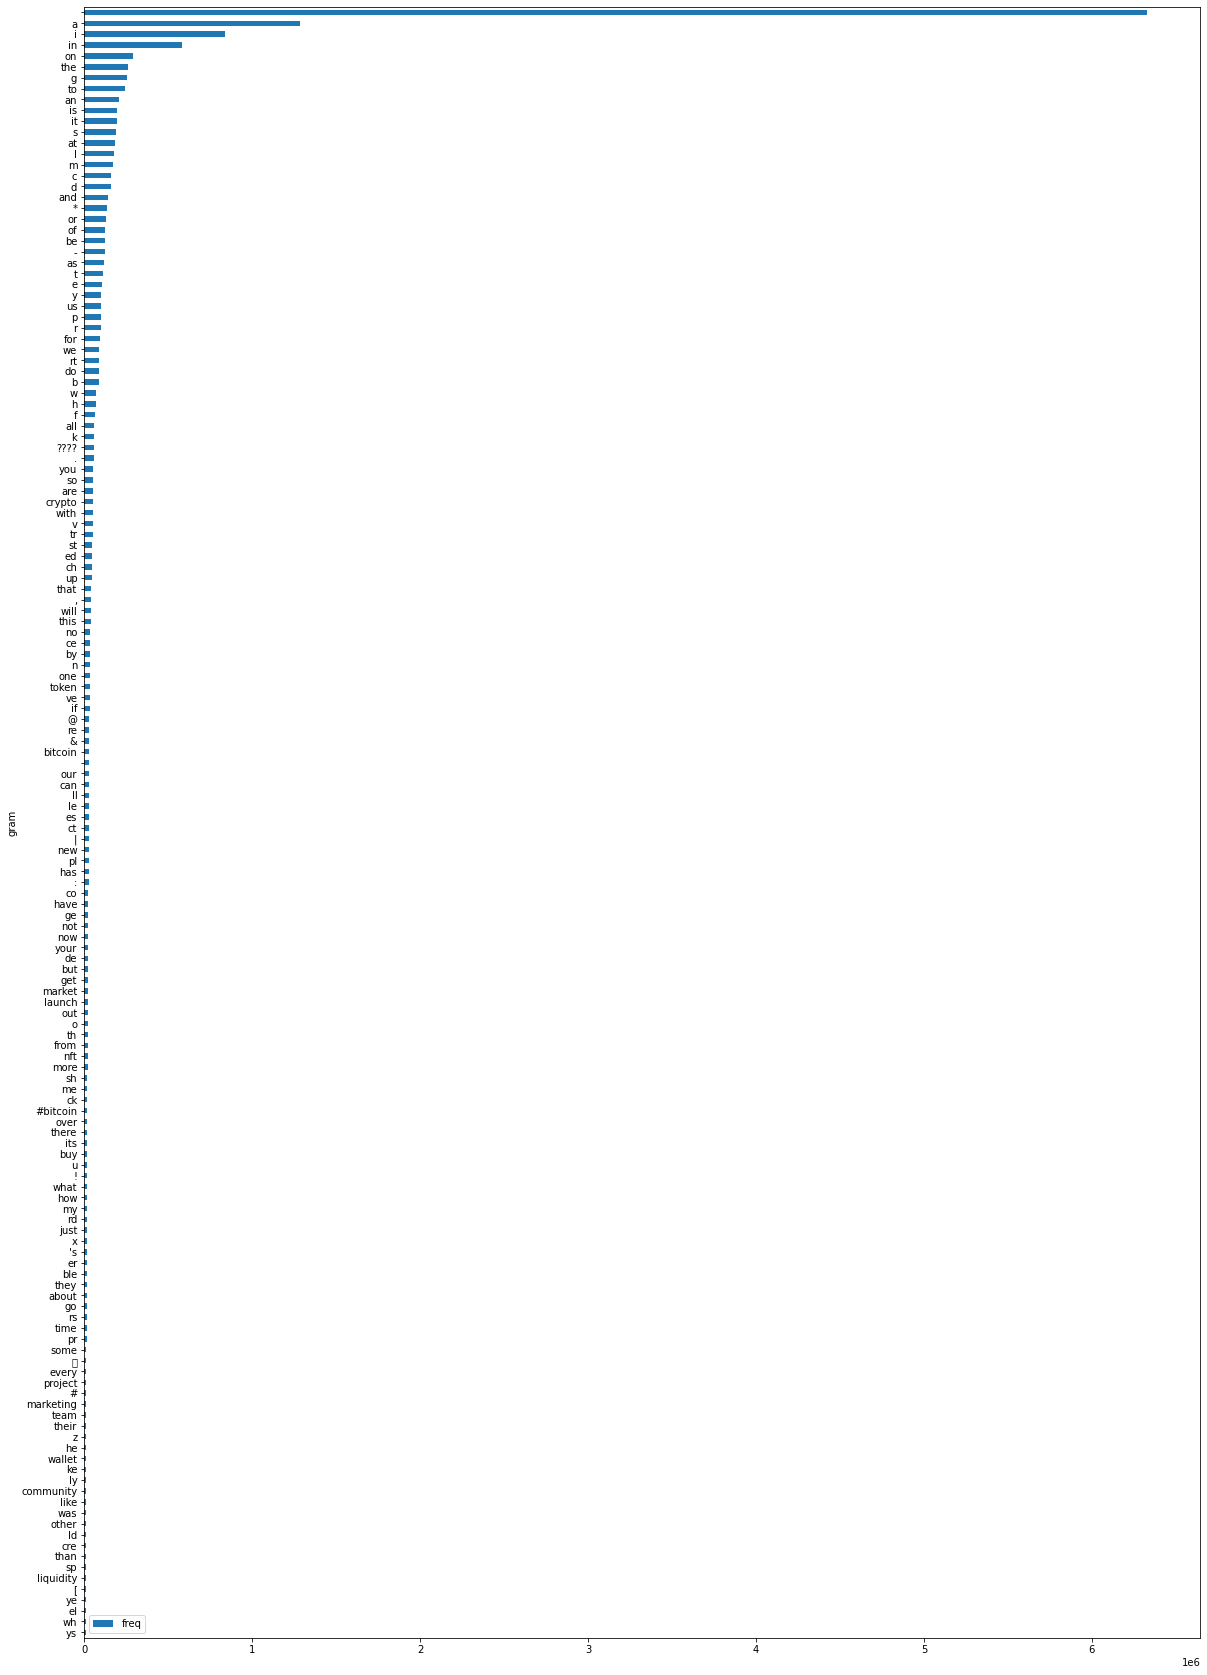

In [65]:
plt.rcParams["figure.figsize"] = (20,30)
print(len(token3_df))
p = token3_df[:150][['gram','freq']].plot.barh(x='gram'); p.invert_yaxis();


In [66]:
counters1[1]['o ']

276357

In [204]:
def get_grams(text,n):
    grams = []
    chars = list(text)
    for i in range(len(chars) - (n-1)):
        gram = None
        for j in range(n):
            gram = chars[i+j] if gram is None else gram + chars[i+j]
        grams.append(gram)
    return grams

def print_grams(counter,text,n):
    grams = get_grams(text,n)
    freqs = counter[n-1]
    for gram in grams:
        print(gram,freqs[gram])

def merge_grams_at(grams,pos):
    length = len(grams)
    if pos == 0:
        return [grams[0]+grams[1][1:]] + grams[2:]
    elif pos == length - 1:
        return grams[:-2] + [grams[length - 2]+grams[length - 1][1:]]
    else:
        return grams[:pos-1] + [  grams[pos-1][:-1] + grams[pos] + grams[pos+1][1:] ] + grams[pos+2:] 
        
        
def marge_grams(counter,text,n_start,n_cycles):
    grams = get_grams(text,n_start)
    for cycle in range(n_cycles):
        max_freq = 0
        max_pos = 0
        for pos in range(len(grams)):
            gram = grams[pos]
            freq = counter[gram] if gram in counter else 0
            print(gram,freq)
            if max_freq < freq:
                max_pos = pos
                max_freq = freq
        print(cycle,'==>',grams[max_pos],max_freq)
        grams = merge_grams_at(grams,max_pos)

# Bigram counts to Mutual Information 
# https://arxiv.org/pdf/cmp-lg/9805009.pdf
# page 40
def counts2mis(bigram_counts,debug=False):
    mis = {}
    n_x_ = {}
    n__y = {}
    n = 0
    for bigram in bigram_counts:
        x = bigram[0]
        y = bigram[1]
        n_xy = bigram_counts[bigram]
        n += n_xy
        count(n_x_,x,n_xy)
        count(n__y,y,n_xy)
    #c = 0
    for bigram in bigram_counts:
        x = bigram[0]
        y = bigram[1]
        n_xy = bigram_counts[bigram]
        if debug:
            print(bigram, x, y, n_xy, n, n_x_[x] , n__y[y])
        mis[bigram] = n_xy * n / (n_x_[x] * n__y[y])
        #c+=1
        #if c > 10:
        #    break
    return mis


def profile_probabilities(counters,text,max_n,debug=False):
    length = len(text)
    de_list = []
    for i in range(1,length):
        start = i - (max_n-1)
        if start < 0:
            start = 0
        pre_gram = text[start:i]
        post_gram = text[start:i+1]
        sym = text[i]
        pre_prob = counters[pre_gram] if pre_gram in counters else 1
        post_prob = counters[post_gram] if post_gram in counters else 0
        prob = post_prob / pre_prob
        if debug:
            print("{}-{}:'{}'-'{}'={}=>{}".format(start,i,post_gram,pre_gram,sym,prob))
        de_list.append((i,sym,prob))
    return de_list


def plot_profile(df,text):
    plt.rcParams["figure.figsize"] = (20,5)
    p = df.plot.bar(x='char')
    p = plt.xticks(rotation='horizontal',fontsize=1+round(60*20/len(text)))

def plot_profile_probabilities(counters,text,max_n,debug=False):
    df = pd.DataFrame(profile_probabilities(counters,text,max_n,debug=debug),columns=['pos','char','prob'])
    #print(df)
    df.set_index('pos',inplace=True)
    plt.rcParams["figure.figsize"] = (20,5)
    p = df.plot.bar(x='char')
    p = plt.xticks(rotation='horizontal',fontsize=1+round(60*20/len(text)))
    return df

print(merge_grams_at(['ab','bc','cd'],0))
print(merge_grams_at(['ab','bc','cd'],1))
print(merge_grams_at(['ab','bc','cd'],2))
print(merge_grams_at(['ab','bc','cd','de'],0))
print(merge_grams_at(['ab','bc','cd','de'],1))
print(merge_grams_at(['ab','bc','cd','de'],2))
print(merge_grams_at(['ab','bc','cd','de'],3))


['abc', 'cd']
['abcd']
['ab', 'bcd']
['abc', 'cd', 'de']
['abcd', 'de']
['ab', 'bcde']
['ab', 'bc', 'cde']


In [187]:
df = pd.DataFrame(profile_probabilities(all_counters1,"the cat sits on a mat",3,True),columns=['pos','char','prob'])
df.set_index('pos',inplace=True)
df

0-1:'th'-'t'=h=>0.176495402643955
0-2:'the'-'th'=e=>0.5924801334157896
1-3:'he '-'he'= =>0.6014123126241192
2-4:'e c'-'e '=c=>0.06006071144520976
3-5:' ca'-' c'=a=>0.17738410333896654
4-6:'cat'-'ca'=t=>0.09101380477844291
5-7:'at '-'at'= =>0.3195327541969369
6-8:'t s'-'t '=s=>0.04526330942836925
7-9:' si'-' s'=i=>0.056129510048020054
8-10:'sit'-'si'=t=>0.15715159598471706
9-11:'its'-'it'=s=>0.05081473566623765
10-12:'ts '-'ts'= =>0.6461010868418275
11-13:'s o'-'s '=o=>0.06918528369803259
12-14:' on'-' o'=n=>0.289392848321662
13-15:'on '-'on'= =>0.376890913226494
14-16:'n a'-'n '=a=>0.09981363116159354
15-17:' a '-' a'= =>0.19153573421161565
16-18:'a m'-'a '=m=>0.05272883429196054
17-19:' ma'-' m'=a=>0.34470621939074797
18-20:'mat'-'ma'=t=>0.09864975184042653


,char,prob
pos,,
1,h,0.176495
2,e,0.592480
3,,0.601412
4,c,0.060061
5,a,0.177384
6,t,0.091014
7,,0.319533
8,s,0.045263
9,i,0.056130


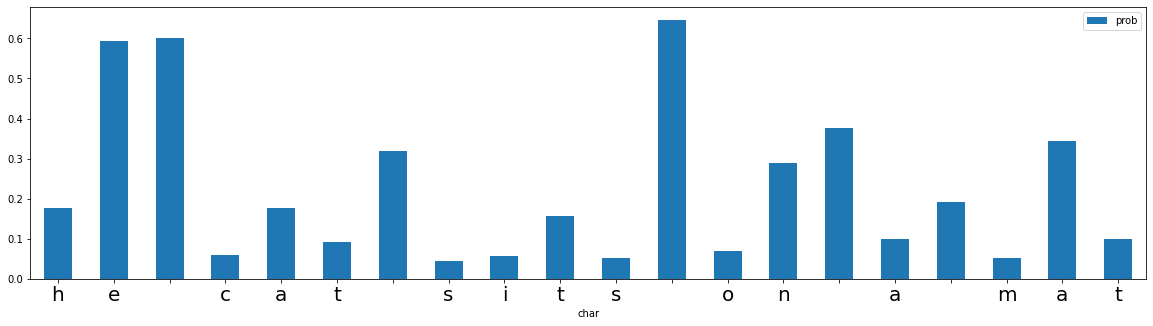

In [188]:
plt.rcParams["figure.figsize"] = (20,5)
p = df.plot.bar(x='char')
p = plt.xticks(rotation='horizontal',fontsize=20)

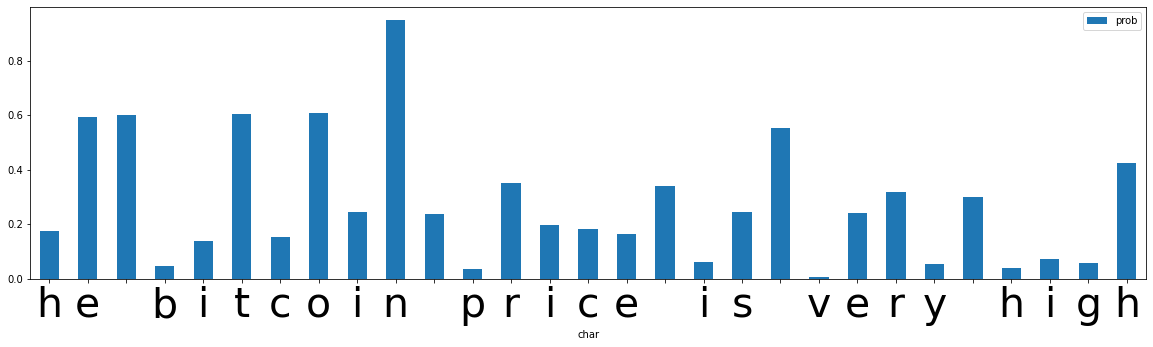

In [189]:
df = plot_profile_probabilities(all_counters1,"the bitcoin price is very high",3,False)

/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129418 (\N{FOX FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/akolonin/Documents/aigents/pygents/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


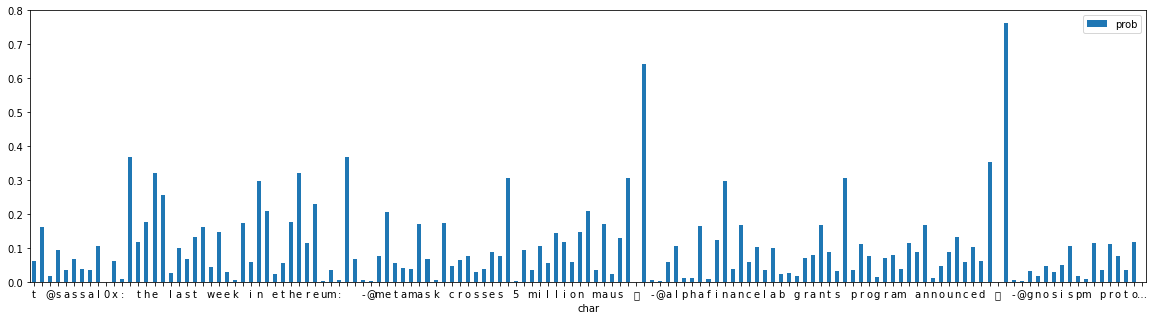

In [198]:
df = plot_profile_probabilities(all_counters1,feeds_df.loc[0]['text'].lower(),3,False)


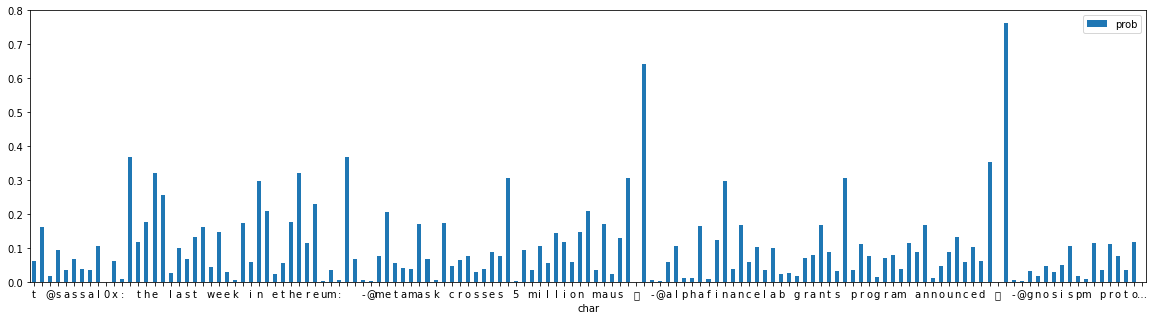

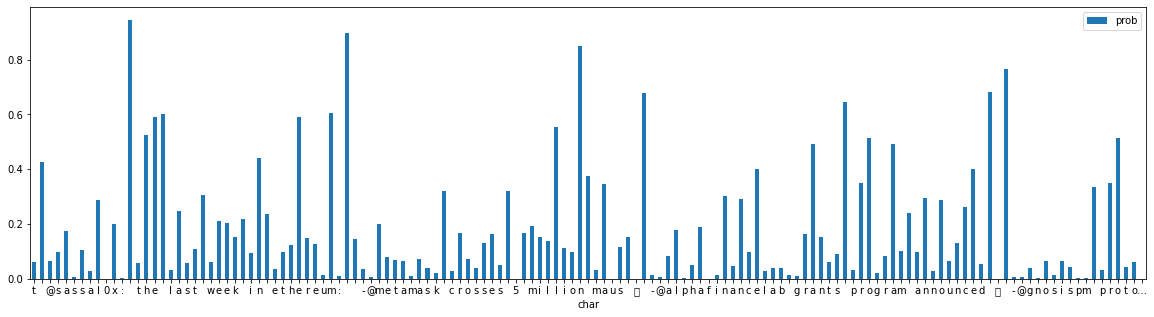

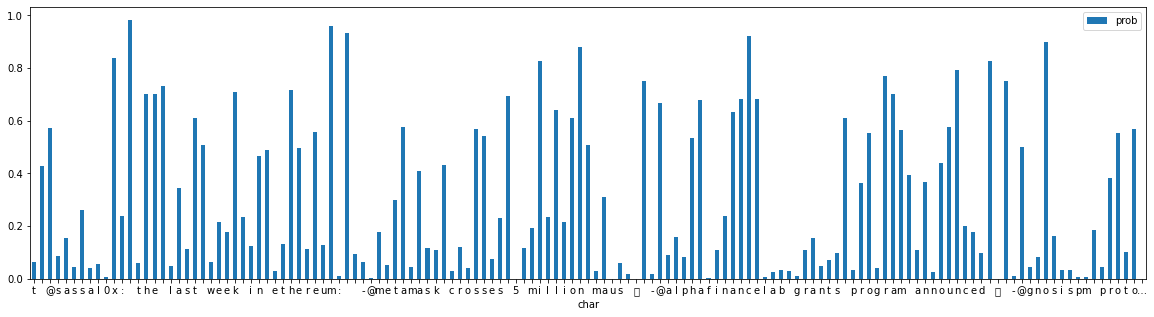

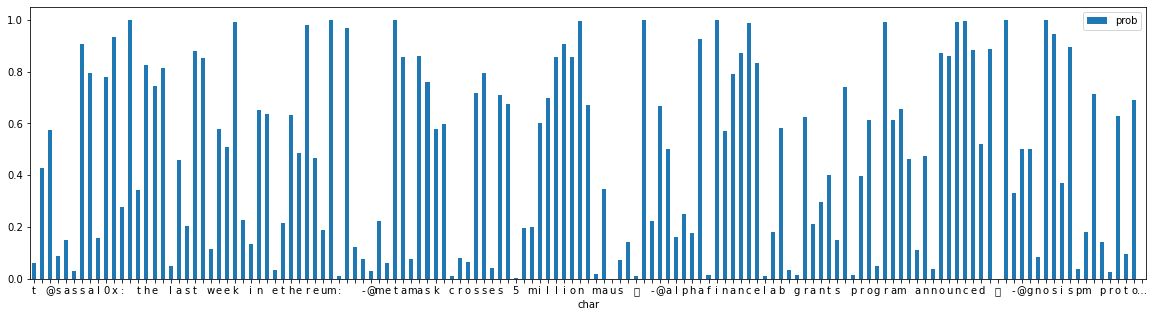

In [205]:
sdf = None
for i in range(2,6):
    df = plot_profile_probabilities(all_counters1,feeds_df.loc[0]['text'].lower(),i,False)
    if sdf is None:
        sdf = df
        sdf['sum'] = df['prob']
        sdf['mul'] = df['prob']
        sdf.drop('prob', inplace=True, axis=1)
    else:
        sdf['sum'] = sdf['sum'] + df['prob']
        sdf['mul'] = sdf['mul'] * df['prob']


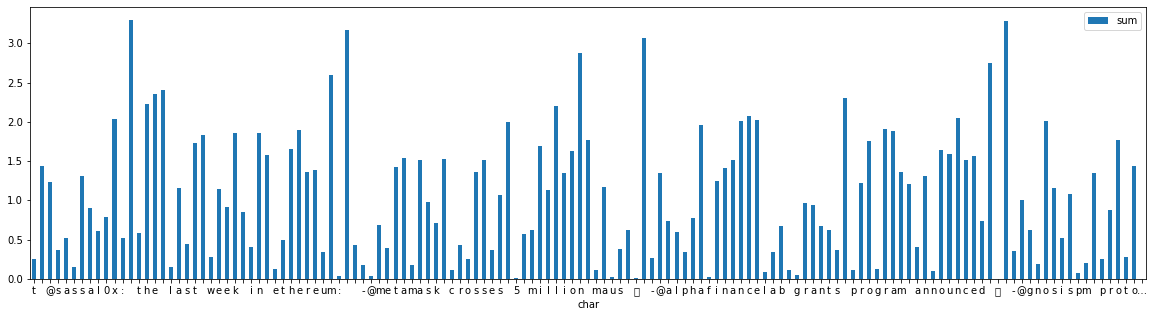

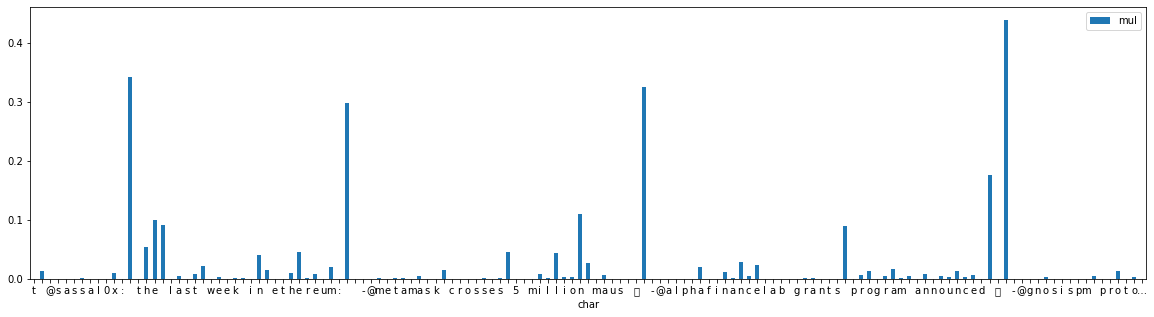

In [208]:
plot_profile(sdf[['char','sum']],feeds_df.loc[0]['text'].lower())
plot_profile(sdf[['char','mul']],feeds_df.loc[0]['text'].lower())


In [192]:
df

,char,prob
pos,,
1,t,0.062611
2,,0.426710
3,@,0.065565
4,s,0.099050
5,a,0.175981
...,...,...
135,r,0.350515
136,o,0.513594
137,t,0.044695


In [197]:
print(all_counters1['@sa']/all_counters1['@s'])
print(all_counters1['rot']/all_counters1['ro'])
print(all_counters1['oto']/all_counters1['ot'])



0.1759809750297265
0.04469455192476064
0.05956968529222865


In [151]:
print_grams(counters1,"year 2022. 2021 is over.",2)


ye 23185
ea 171646
ar 262170
r  268320
 2 34170
20 26239
02 13539
22 7377
2. 4013
.  208107
 2 34170
20 26239
02 13539
21 10498
1  14556
 i 364853
is 231598
s  615073
 o 287457
ov 40253
ve 193907
er 378807
r. 17528


In [152]:
marge_grams(all_counters1,"year 2022. 2021 is over.",2,2)


ye 23185
ea 171646
ar 262170
r  268320
 2 34170
20 26239
02 13539
22 7377
2. 4013
.  208107
 2 34170
20 26239
02 13539
21 10498
1  14556
 i 364853
is 231598
s  615073
 o 287457
ov 40253
ve 193907
er 378807
r. 17528
0 ==> s  615073
ye 23185
ea 171646
ar 262170
r  268320
 2 34170
20 26239
02 13539
22 7377
2. 4013
.  208107
 2 34170
20 26239
02 13539
21 10498
1  14556
 i 364853
is o 5074
ov 40253
ve 193907
er 378807
r. 17528
1 ==> er 378807


In [93]:
counters_test = grams_init(max_n)
#text_grams_count(counters_test,"bob rob job",max_n)
text_grams_count(counters_test,"ababxyz",max_n)
counters_mis = counts2mis(counters_test[1],True)
counters_mis_df = pd.DataFrame([(gram, counters_mis[gram]) for gram in counters_mis],columns=['gram','mi'])
counters_mis_df['log'] = np.log10(counters_mis_df['mi'])
counters_mis_df.sort_values('mi',ascending=False,inplace=True)
counters_mis_df

ab a b 2 6 2 2
ba b a 1 6 2 1
bx b x 1 6 2 1
xy x y 1 6 1 1
yz y z 1 6 1 1


,gram,mi,log
3,xy,6.0,0.778151
4,yz,6.0,0.778151
0,ab,3.0,0.477121
1,ba,3.0,0.477121
2,bx,3.0,0.477121


In [91]:
counters_test[1]

{'ab': 2, 'ba': 1, 'bx': 1, 'xy': 1, 'yz': 1}

In [70]:
mis1 = counts2mis(counters1[1])

In [71]:
mis1['s.']

2.438062060028852

In [72]:
print_grams([None,mis1],"the blockchain is great",2)

th 5.891832418429718
he 3.994436969135652
e  1.6597529331265277
 b 2.984543518172481
bl 2.5090739166351503
lo 1.4892256167876545
oc 0.8012729355298925
ck 5.580358721588415
kc 0.7348280366774312
ch 3.7796499741292733
ha 2.9192300192541296
ai 0.7461836645230092
in 5.814439636547122
n  1.3655964572121528
 i 1.0763887520777022
is 2.157051860017478
s  2.002431654260816
 g 1.0721333089357208
gr 1.5708239490733118
re 2.8555187843012537
ea 0.9189902411479491
at 1.398471458831117


In [74]:
mis1_df = pd.DataFrame([(gram, mis1[gram]) for gram in mis1],columns=['gram','mi'])
mis1_df['log'] = np.log10(mis1_df['mi'])
mis1_df.sort_values('mi',ascending=False,inplace=True)

In [78]:
mis1_df

,gram,mi,log
15585,̼̗,4.115994e+07,7.614475
21695,边缘,4.115994e+07,7.614475
15586,̗̎,4.115994e+07,7.614475
20144,感激,4.115994e+07,7.614475
15587,̎̽,4.115994e+07,7.614475
...,...,...,...
21539,e$,2.876496e-04,-3.541136
6695,:o,2.806680e-04,-3.551807
9873,:e,2.563323e-04,-3.591197
12372,!e,2.061183e-04,-3.685883


<AxesSubplot:>

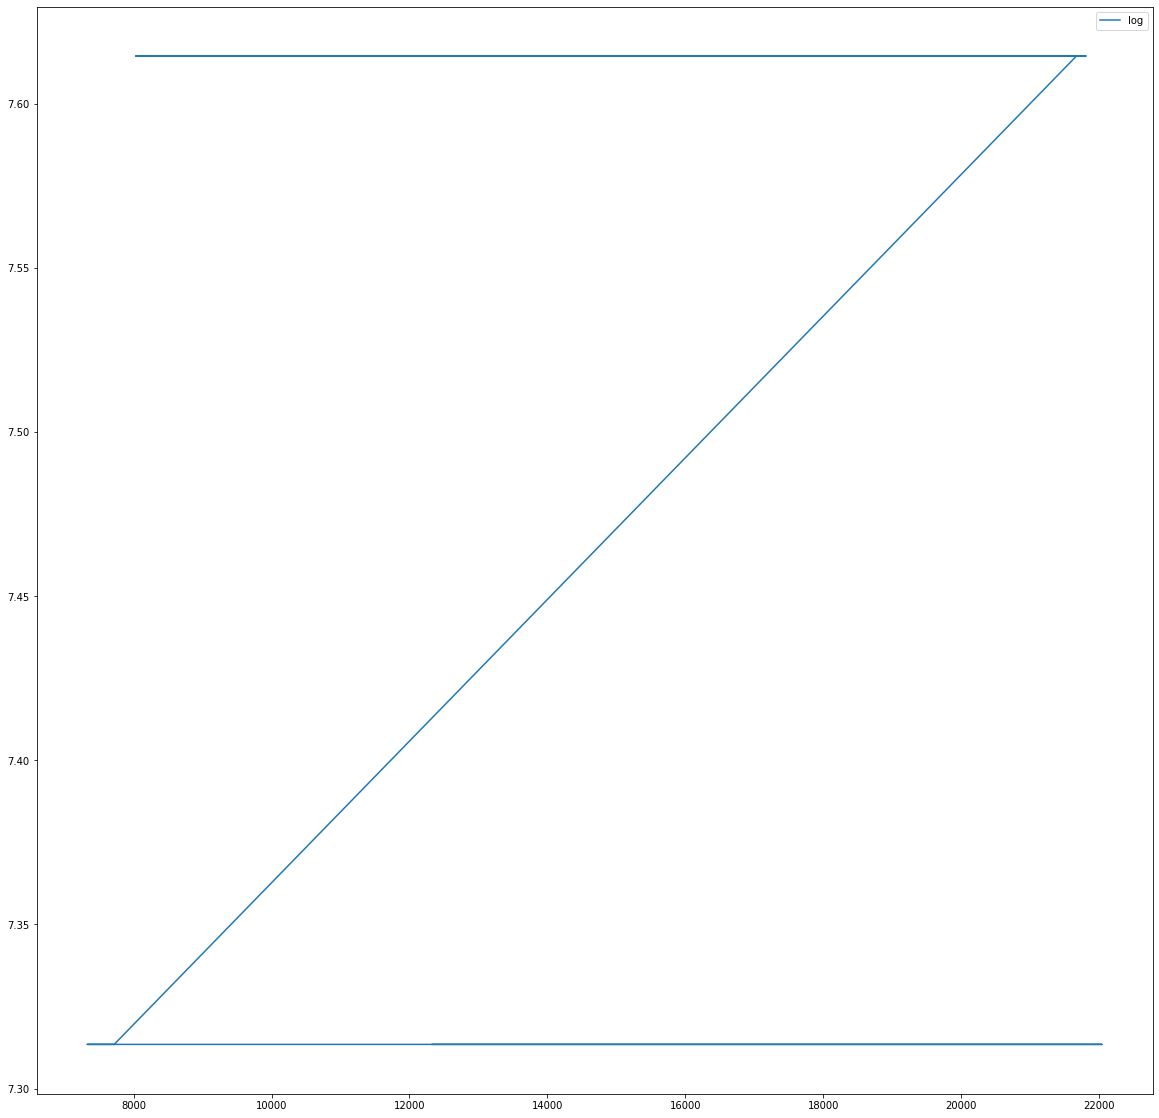

In [85]:
mis1_df[:200][['log']].plot()

In [38]:
# "Year 2022. 2021 is over." / "Balance is 2022.2021."





In [39]:
#TODO tokenize by clustering words in the sentence by gram counts - using MUTUAL INFORMATION!!!

#TODO how to split endings delimiters away from words!?

#TODO inhibit frequencies from higher-order to lower-order?

#TODO decapitalization?

#TODO decode '\u200b'


